# Used Car Price Prediction Using Regression Models


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.preprocessing import LabelEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

import time
import warnings
warnings.filterwarnings('ignore')

## Trial 1: Baseline Models (No Feature Engineering)


Data Loading

In [2]:
df_train_base = pd.read_csv('train-data.csv')

df_train_base.head()
df_train_base.info()
df_train_base.describe()
df_train_base.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


Unnamed: 0              0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

Data Cleaning

In [3]:
# Basic cleaning: drop rows with any missing values, drop non-useful columns
df_train_base.drop(columns=['Unnamed: 0'], inplace=True, errors='ignore')
df_train_base.dropna(inplace=True)

# Extract numeric parts from string columns (same as later code)
df_train_base['Engine'] = df_train_base['Engine'].astype(str).str.extract(r'([\d.]+)')[0].astype(float)
df_train_base['Power'] = df_train_base['Power'].astype(str).str.extract(r'([\d.]+)')[0].astype(float)
df_train_base['New_Price'] = df_train_base['New_Price'].astype(str).str.extract(r'([\d.]+)')[0].astype(float)

# Drop Mileage
df_train_base.drop(columns=['Mileage'], inplace=True, errors='ignore')

# Drop rows still having NaN after extraction (e.g., 'null bhp')
df_train_base.dropna(inplace=True)

Feature Encoding

In [4]:
# Simple Label Encoding for all categorical columns
categorical_cols_base = ['Name', 'Location', 'Fuel_Type', 'Transmission', 'Owner_Type']
for col in categorical_cols_base:
    le = LabelEncoder()
    df_train_base[col] = le.fit_transform(df_train_base[col].astype(str))

Train-Test Then Train-Validate Split

In [5]:
# Features and target
X_base = df_train_base.drop('Price', axis=1)
y_base = df_train_base['Price']

# First split: 80% train_full, 20% test
X_train_full_base, X_test_base, y_train_full_base, y_test_base = train_test_split(
    X_base, y_base, test_size=0.2, random_state=42
)

# Second split: from the 80% train_full, take 80% as train and 20% as validation
X_train_base, X_val_base, y_train_base, y_val_base = train_test_split(
    X_train_full_base, y_train_full_base, test_size=0.2, random_state=42
)

Models and Evaluation

In [6]:
# Baseline models (no scaling, no hyperparameter tuning)
baseline_models = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ]),

    "PolynomialRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("lr", LinearRegression())
    ]),

    "PolynomialRidge": Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("ridge", Ridge())  # default alpha = 1.0
    ]),

    "PolynomialLasso": Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(degree=2, include_bias=False)),
        ("lasso", Lasso(max_iter=10000))  # default alpha = 1.0
    ]),

    "DecisionTree": DecisionTreeRegressor(random_state=42),

    "RandomForest": RandomForestRegressor(random_state=42),

    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}

In [7]:
print("\nBaseline Validation & Test Results:")

baseline_results = {}

for name, model in baseline_models.items():
    start = time.time()

    # Train on training split
    model.fit(X_train_base, y_train_base)

    # Validation predictions
    val_preds = model.predict(X_val_base)

    # Test predictions
    test_preds = model.predict(X_test_base)

    end = time.time()

    # Validation metrics
    val_rmse = np.sqrt(mean_squared_error(y_val_base, val_preds))
    val_mae = mean_absolute_error(y_val_base, val_preds)
    val_r2 = r2_score(y_val_base, val_preds)

    # Test metrics
    test_rmse = np.sqrt(mean_squared_error(y_test_base, test_preds))
    test_mae = mean_absolute_error(y_test_base, test_preds)
    test_r2 = r2_score(y_test_base, test_preds)

    baseline_results[name] = {
        "Val_RMSE": val_rmse,
        "Val_MAE": val_mae,
        "Val_R2": val_r2,
        "Test_RMSE": test_rmse,
        "Test_MAE": test_mae,
        "Test_R2": test_r2,
        "Time": end - start
    }

    print(
        f"{name} | "
        f"Val RMSE: {val_rmse:.4f}, Val R2: {val_r2:.4f} | "
        f"Test RMSE: {test_rmse:.4f}, Test R2: {test_r2:.4f} | "
        f"Time: {end-start:.2f}s"
    )

baseline_df = pd.DataFrame(baseline_results).T
print("\nBaseline Summary Table (Validation + Test):\n")
display(baseline_df.round(4))


Baseline Validation & Test Results:
LinearRegression | Val RMSE: 5.3538, Val R2: 0.7705 | Test RMSE: 7.4583, Test R2: 0.7255 | Time: 0.01s
PolynomialRegression | Val RMSE: 5.8116, Val R2: 0.7296 | Test RMSE: 11.0547, Test R2: 0.3970 | Time: 0.01s
PolynomialRidge | Val RMSE: 5.8397, Val R2: 0.7270 | Test RMSE: 10.3034, Test R2: 0.4762 | Time: 0.01s
PolynomialLasso | Val RMSE: 4.1223, Val R2: 0.8639 | Test RMSE: 5.9206, Test R2: 0.8270 | Time: 0.01s
DecisionTree | Val RMSE: 5.5706, Val R2: 0.7515 | Test RMSE: 5.5896, Test R2: 0.8458 | Time: 0.01s
RandomForest | Val RMSE: 7.4814, Val R2: 0.5519 | Test RMSE: 5.7817, Test R2: 0.8351 | Time: 0.25s
GradientBoosting | Val RMSE: 5.6883, Val R2: 0.7409 | Test RMSE: 5.1694, Test R2: 0.8682 | Time: 0.09s

Baseline Summary Table (Validation + Test):



,Val_RMSE,Val_MAE,Val_R2,Test_RMSE,Test_MAE,Test_R2,Time
LinearRegression,5.3538,3.6269,0.7705,7.4583,4.5610,0.7255,0.0057
PolynomialRegression,5.8116,3.2673,0.7296,11.0547,4.7315,0.3970,0.0117
PolynomialRidge,5.8397,3.2454,0.7270,10.3034,4.4969,0.4762,0.0087
PolynomialLasso,4.1223,2.6266,0.8639,5.9206,2.9750,0.8270,0.0075
DecisionTree,5.5706,2.4227,0.7515,5.5896,2.6164,0.8458,0.0060
RandomForest,7.4814,2.1171,0.5519,5.7817,1.9775,0.8351,0.2475
GradientBoosting,5.6883,1.8453,0.7409,5.1694,2.1030,0.8682,0.0879


### Baseline Model Analysis

Overall, the baseline results indicate a balanced trade-off between model bias and variance, with limited evidence of systematic underfitting or overfitting across most models. Linear Regression achieves reasonable validation and test performance, suggesting that the simplest model is sufficient to capture the core structure of the data and does not suffer from high bias.

Unregularized Polynomial Regression exhibits clear signs of overfitting, with strong validation performance but a substantial degradation on the test set. This indicates that the added model complexity increases variance without improving generalisation. Introducing regularisation mitigates this effect: Polynomial Ridge reduces overfitting to some extent, while Polynomial Lasso effectively controls model complexity by shrinking or eliminating redundant polynomial features, resulting in strong and stable performance across validation and test sets.

Tree-based and ensemble models demonstrate robust generalisation. Although minor discrepancies between validation and test performance are observed, these differences are attributable to data split variability rather than overfitting. In particular, Gradient Boosting achieves the best test performance, reflecting an effective balance between bias and variance.


## Trial 2: Data Cleaning, Feature Engineering and Hyperparameter Tuning


Data Loading

In [8]:
df_train = pd.read_csv('train-data.csv')

df_train.head()
df_train.info()
df_train.describe()
df_train.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6019 entries, 0 to 6018
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         6019 non-null   int64  
 1   Name               6019 non-null   object 
 2   Location           6019 non-null   object 
 3   Year               6019 non-null   int64  
 4   Kilometers_Driven  6019 non-null   int64  
 5   Fuel_Type          6019 non-null   object 
 6   Transmission       6019 non-null   object 
 7   Owner_Type         6019 non-null   object 
 8   Mileage            6017 non-null   object 
 9   Engine             5983 non-null   object 
 10  Power              5983 non-null   object 
 11  Seats              5977 non-null   float64
 12  New_Price          824 non-null    object 
 13  Price              6019 non-null   float64
dtypes: float64(2), int64(3), object(9)
memory usage: 658.5+ KB


Unnamed: 0              0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 2
Engine                 36
Power                  36
Seats                  42
New_Price            5195
Price                   0
dtype: int64

In [9]:
df_test = pd.read_csv('test-data.csv')

df_test.head()
df_test.info()
df_test.describe()
df_test.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1234 entries, 0 to 1233
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Unnamed: 0         1234 non-null   int64  
 1   Name               1234 non-null   object 
 2   Location           1234 non-null   object 
 3   Year               1234 non-null   int64  
 4   Kilometers_Driven  1234 non-null   int64  
 5   Fuel_Type          1234 non-null   object 
 6   Transmission       1234 non-null   object 
 7   Owner_Type         1234 non-null   object 
 8   Mileage            1234 non-null   object 
 9   Engine             1224 non-null   object 
 10  Power              1224 non-null   object 
 11  Seats              1223 non-null   float64
 12  New_Price          182 non-null    object 
dtypes: float64(1), int64(3), object(9)
memory usage: 125.5+ KB


Unnamed: 0              0
Name                    0
Location                0
Year                    0
Kilometers_Driven       0
Fuel_Type               0
Transmission            0
Owner_Type              0
Mileage                 0
Engine                 10
Power                  10
Seats                  11
New_Price            1052
dtype: int64

Data Cleaning (Training Data)

In [10]:
#Convert New_Price to numeric
df_train['New_Price'] = df_train['New_Price'].astype(str).str.extract(r'([\d\.]+)')[0].astype(float)

#Extract Brand from Name
df_train['Brand'] = df_train['Name'].str.split().str[0]

#Fill missing New_Price based on skewness
skewness_NP = df_train['New_Price'].skew()
fill_stat_NP = 'median' if abs(skewness_NP) > 0.5 else 'mean'
if fill_stat_NP == 'mean':
    brand_price = df_train.groupby('Brand')['New_Price'].mean()
else:
    brand_price = df_train.groupby('Brand')['New_Price'].median()

df_train['New_Price'] = df_train['New_Price'].fillna(df_train['Brand'].map(brand_price))

#Global Fill for New_Price for Brands with No Single New_Price Value
df_train['New_Price'].fillna(df_train['New_Price'].median(), inplace=True)

#Fill Seats by Brand mode
brand_seats_mode = df_train.groupby('Brand')['Seats'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df_train['Seats'] = df_train['Seats'].fillna(df_train['Brand'].map(brand_seats_mode))

#Drop unnecessary columns
df_train.drop(columns=['Mileage', 'Unnamed: 0'], inplace=True, errors='ignore')

#Convert Engine and Power to numeric
df_train['Engine'] = df_train['Engine'].astype(str).str.extract(r'([\d\.]+)')[0].astype(float)
df_train['Power'] = df_train['Power'].astype(str).str.extract(r'([\d\.]+)')[0].astype(float)

#Drop rows with remaining missing Engine/Power
df_train.dropna(subset=['Engine','Power'], inplace=True)


Data Cleaning (Test Data)

In [11]:
#Convert New_Price to numeric
df_test['New_Price'] = df_test['New_Price'].astype(str).str.extract(r'([\d\.]+)')[0].astype(float)

#Extract Brand from Name
df_test['Brand'] = df_test['Name'].str.split().str[0]

#Fill missing New_Price based on skewness
skewness = df_test['New_Price'].skew()
fill_stat = 'median' if abs(skewness) > 0.5 else 'mean'
if fill_stat == 'mean':
    brand_price = df_test.groupby('Brand')['New_Price'].mean()
else:
    brand_price = df_test.groupby('Brand')['New_Price'].median()

df_test['New_Price'] = df_test['New_Price'].fillna(df_test['Brand'].map(brand_price))

#Global Fill for New_Price for Brands with No Single New_Price Value
df_test['New_Price'].fillna(df_test['New_Price'].median(), inplace=True)

#Fill Seats by Brand mode
brand_seats_mode = df_test.groupby('Brand')['Seats'].agg(lambda x: x.mode().iloc[0] if not x.mode().empty else np.nan)
df_test['Seats'] = df_test['Seats'].fillna(df_test['Brand'].map(brand_seats_mode))

#Drop unnecessary columns
df_test.drop(columns=['Mileage', 'Unnamed: 0'], inplace=True, errors='ignore')

#Convert Engine and Power to numeric
df_test['Engine'] = df_test['Engine'].astype(str).str.extract(r'([\d\.]+)')[0].astype(float)
df_test['Power'] = df_test['Power'].astype(str).str.extract(r'([\d\.]+)')[0].astype(float)

#Drop rows with remaining missing Engine/Power
df_test.dropna(subset=['Engine','Power'], inplace=True)

Exploratory Data Analysis (EDA)

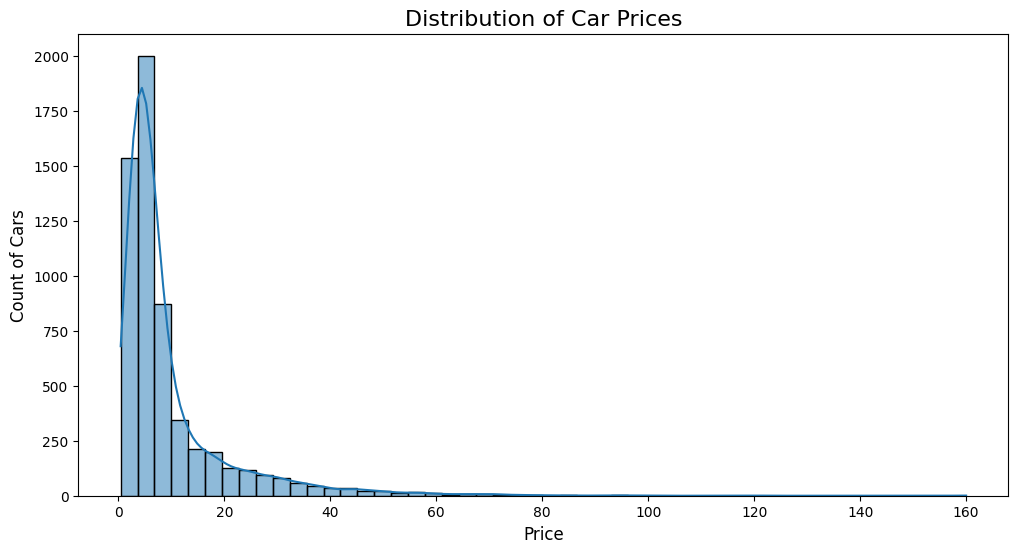

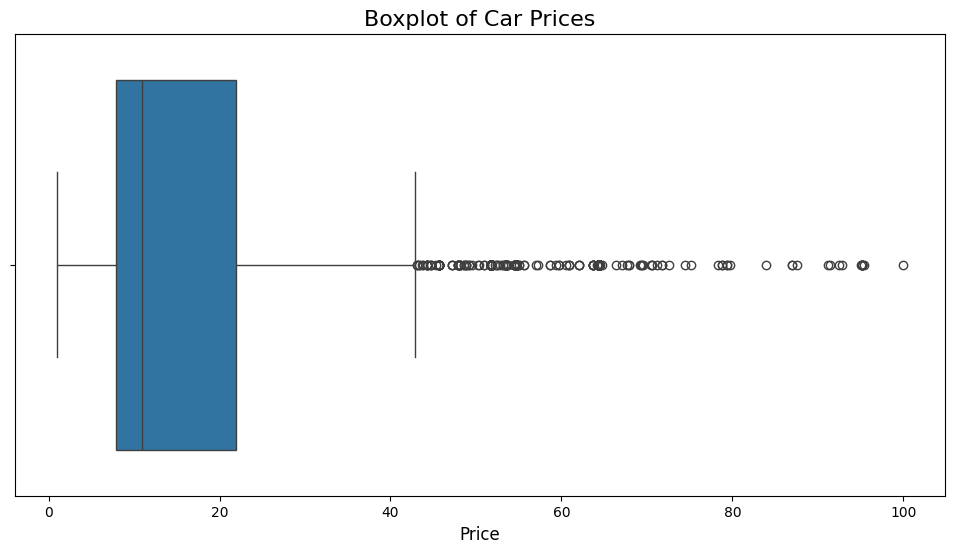

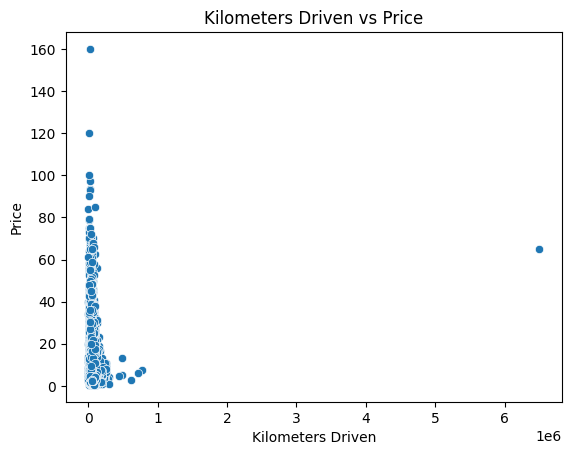

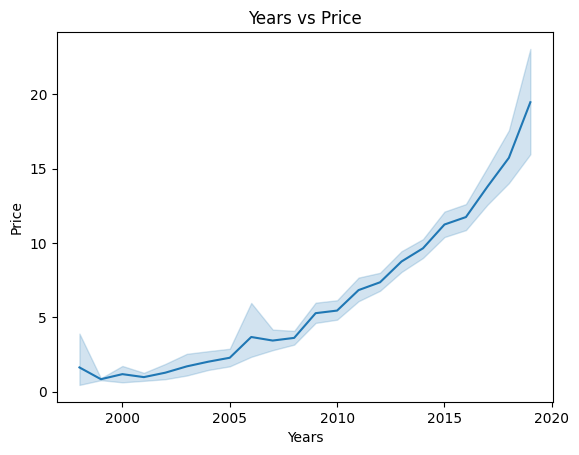

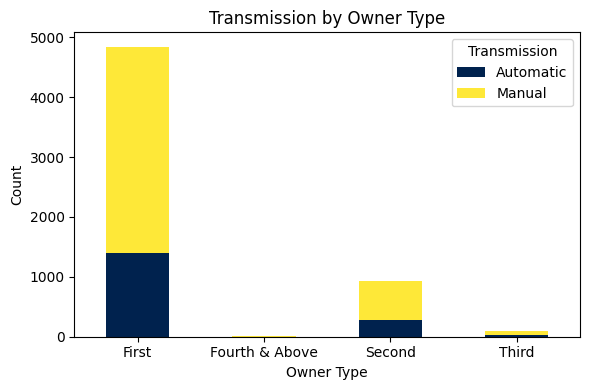

In [12]:
plt.figure(figsize=(12, 6))
sns.histplot(df_train['Price'], kde=True, bins=50)
plt.title('Distribution of Car Prices', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.ylabel('Count of Cars', fontsize=12)
plt.show()


plt.figure(figsize=(12, 6))
sns.boxplot(x=df_train['New_Price'])
plt.title('Boxplot of Car Prices', fontsize=16)
plt.xlabel('Price', fontsize=12)
plt.show()

sns.scatterplot(
   data=df_train,x='Kilometers_Driven',y='Price')
plt.title('Kilometers Driven vs Price')
plt.xlabel('Kilometers Driven')
plt.ylabel('Price')
plt.show()

sns.lineplot(
   data=df_train,x='Year',y='Price')
plt.title('Years vs Price')
plt.xlabel('Years')
plt.ylabel('Price')
plt.show()

owner_trans = pd.crosstab(df_train['Owner_Type'], df_train['Transmission'])

owner_trans.plot(
   kind='bar',
   stacked=True,
   colormap='cividis',
   figsize=(6,4)
)

plt.title('Transmission by Owner Type')
plt.xlabel('Owner Type')
plt.ylabel('Count')
plt.legend(title='Transmission')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

Outlier Treatment Using IQR Clipping

Original boxplots (before clipping):


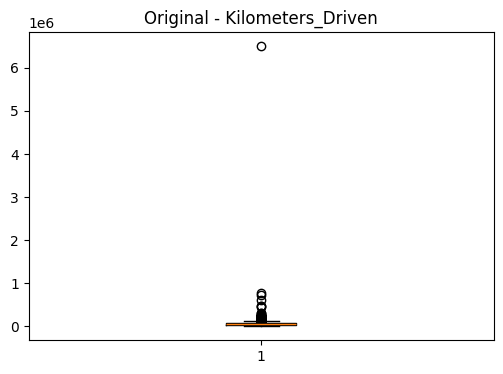

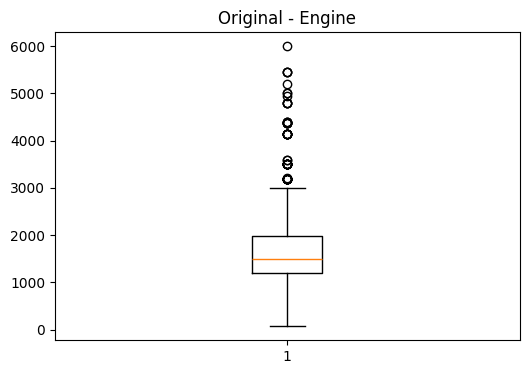

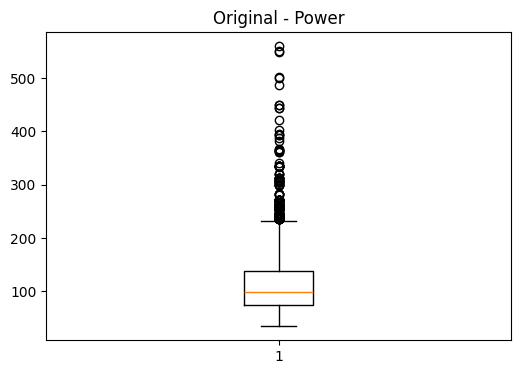

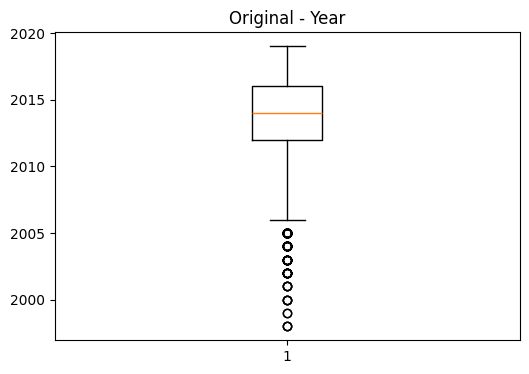

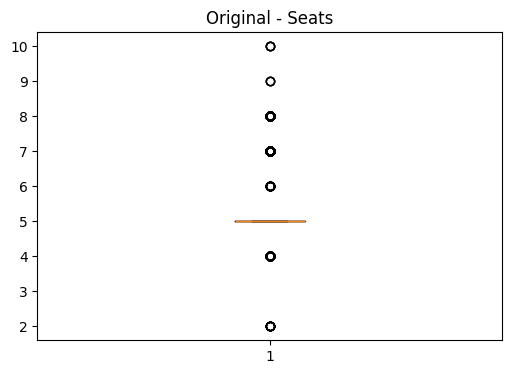

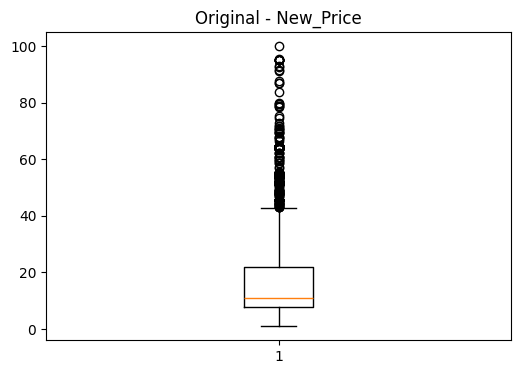

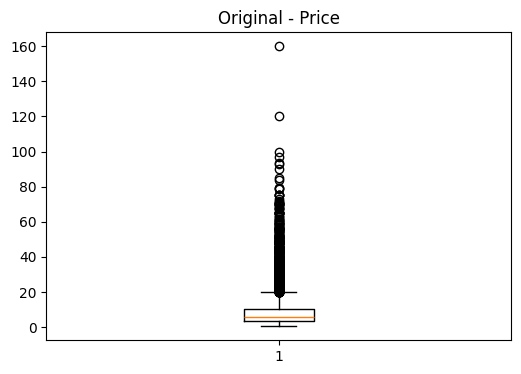


IQR Bounds for clipping:
Kilometers_Driven: [-83433.25, 189279.75]
Engine: [-1181.00, 4370.00]
Power: [-114.30, 327.40]
Year: [2000.00, 2028.00]
Seats: [5.00, 5.00]
New_Price: [-34.12, 63.95]
Price: [-15.97, 29.50]

New Min/Max values after clipping:
     Kilometers_Driven  Engine  Power  Year  Seats  New_Price    Price
min             171.00    72.0   34.2  2000    5.0       1.00   0.4400
max          189279.75  4370.0  327.4  2019    5.0      63.95  29.4975

Boxplots after clipping:


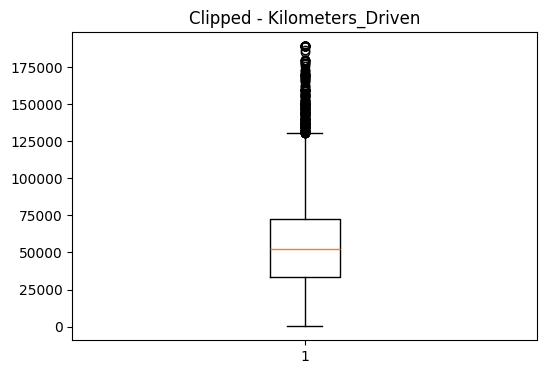

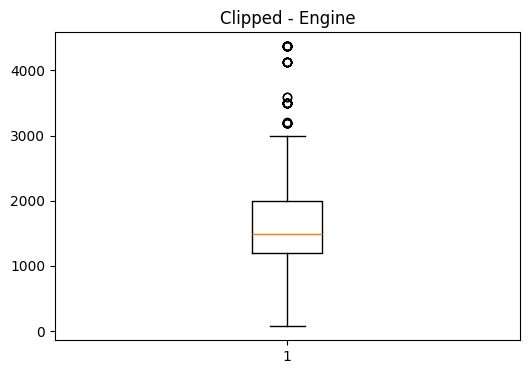

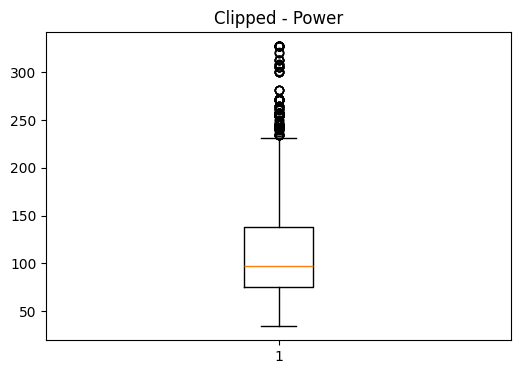

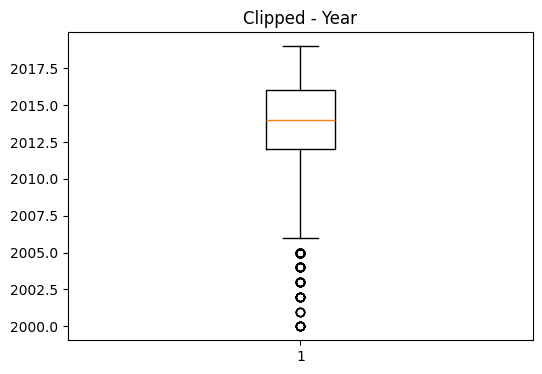

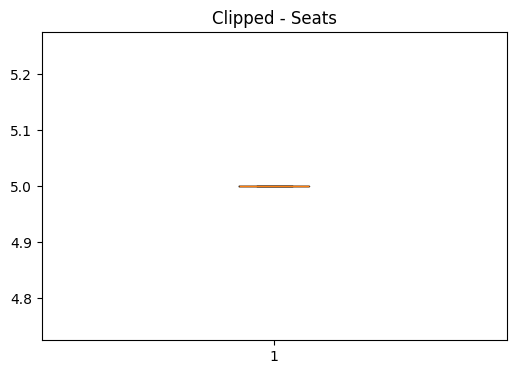

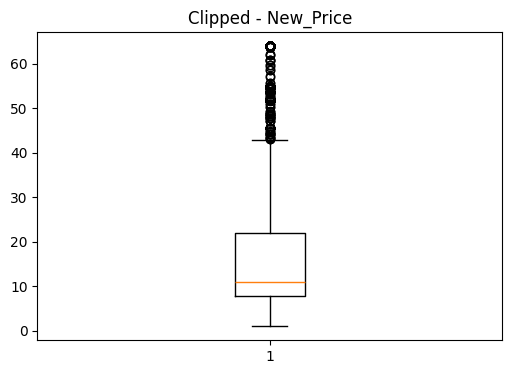

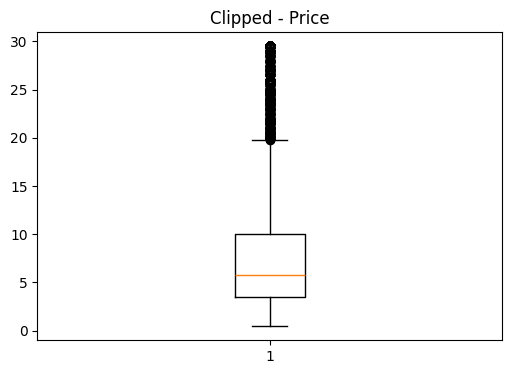

In [13]:
df_train_clipped = df_train.copy()

numerical_cols = ['Kilometers_Driven', 'Engine', 'Power', 'Year', 'Seats', 'New_Price', 'Price']

print("Original boxplots (before clipping):")
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    plt.boxplot(df_train[col].dropna())
    plt.title(f'Original - {col}')
    plt.show()

print("\nIQR Bounds for clipping:")
for col in numerical_cols:

    #Calculate IQR
    Q1 = df_train_clipped[col].quantile(0.25)
    Q3 = df_train_clipped[col].quantile(0.75)
    IQR = Q3 - Q1

    #Define Bounds
    lower = Q1 - 3 * IQR
    upper = Q3 + 3 * IQR
    print(f"{col}: [{lower:.2f}, {upper:.2f}]")

    #Apply Clipping
    df_train_clipped[col] = df_train_clipped[col].clip(lower=lower, upper=upper)

print("\nNew Min/Max values after clipping:")
print(df_train_clipped[numerical_cols].agg(['min', 'max']))

print("\nBoxplots after clipping:")
for col in numerical_cols:
    plt.figure(figsize=(6,4))
    plt.boxplot(df_train_clipped[col].dropna())
    plt.title(f'Clipped - {col}')
    plt.show()

Feature Encoding

In [14]:
#Save original unencoded & unscaled test features for final predictions
df_test_original = df_test.copy()

categorical_cols = ['Name', 'Transmission', 'Location', 'Fuel_Type', 'Brand']

for col in categorical_cols:
    le = LabelEncoder() # Initialize a new LabelEncoder for each column

    # Concatenate all unique values from train, clipped_train, and test for fitting
    # Convert to string first, as LabelEncoder expects string categories if fitted on them.
    all_categories = pd.concat([df_train[col], df_train_clipped[col], df_test[col]], axis=0).astype(str).unique()
    le.fit(all_categories)

    # Transform each DataFrame's column using the fitted encoder
    df_train[col] = le.transform(df_train[col].astype(str))
    df_train_clipped[col] = le.transform(df_train_clipped[col].astype(str))
    df_test[col] = le.transform(df_test[col].astype(str))

df_train['Owner_Type_Encoded'] = df_train['Owner_Type'].map({'First':1,'Second':2,'Third':3,'Fourth & Above':4})
df_train.drop('Owner_Type', axis=1, inplace=True)

df_train_clipped['Owner_Type_Encoded'] = df_train_clipped['Owner_Type'].map({'First':1,'Second':2,'Third':3,'Fourth & Above':4})
df_train_clipped.drop('Owner_Type', axis=1, inplace=True)

df_test['Owner_Type_Encoded'] = df_test['Owner_Type'].map({'First':1,'Second':2,'Third':3,'Fourth & Above':4})
df_test.drop('Owner_Type', axis=1, inplace=True)


Train-Test Then Train-Validate Split

In [15]:
numeric_cols_scaling = ['Year', 'Kilometers_Driven', 'Engine', 'Power', 'Seats', 'New_Price']
X_full_u = df_train.drop('Price', axis=1)
y_u = df_train['Price']
X_train_full_u, X_test_u, y_train_full_u, y_test_u = train_test_split(X_full_u, y_u, test_size=0.2, random_state=42)
X_train_u, X_val_u, y_train_u, y_val_u = train_test_split(X_train_full_u, y_train_full_u, test_size=0.2, random_state=42)

X_full_c = df_train_clipped.drop('Price', axis=1)
y_c = df_train_clipped['Price']
X_train_full_c, X_test_c, y_train_full_c, y_test_c = train_test_split(X_full_c, y_c, test_size=0.2, random_state=42)
X_train_c, X_val_c, y_train_c, y_val_c = train_test_split(X_train_full_c, y_train_full_c, test_size=0.2, random_state=42)

Correlation EDA For Manual Selection (Post Encoding)

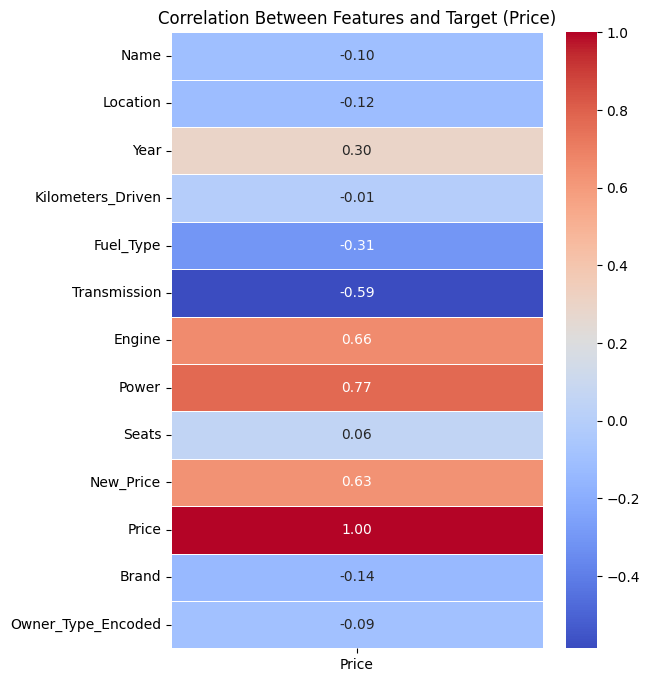

In [16]:
# Correlation with target Price
price_corr = df_train.corr()[['Price']]

plt.figure(figsize=(6, 8))
sns.heatmap(
    price_corr,
    annot=True,
    cmap='coolwarm',
    fmt='.2f',
    linewidths=0.5
)
plt.title('Correlation Between Features and Target (Price)')
plt.show()

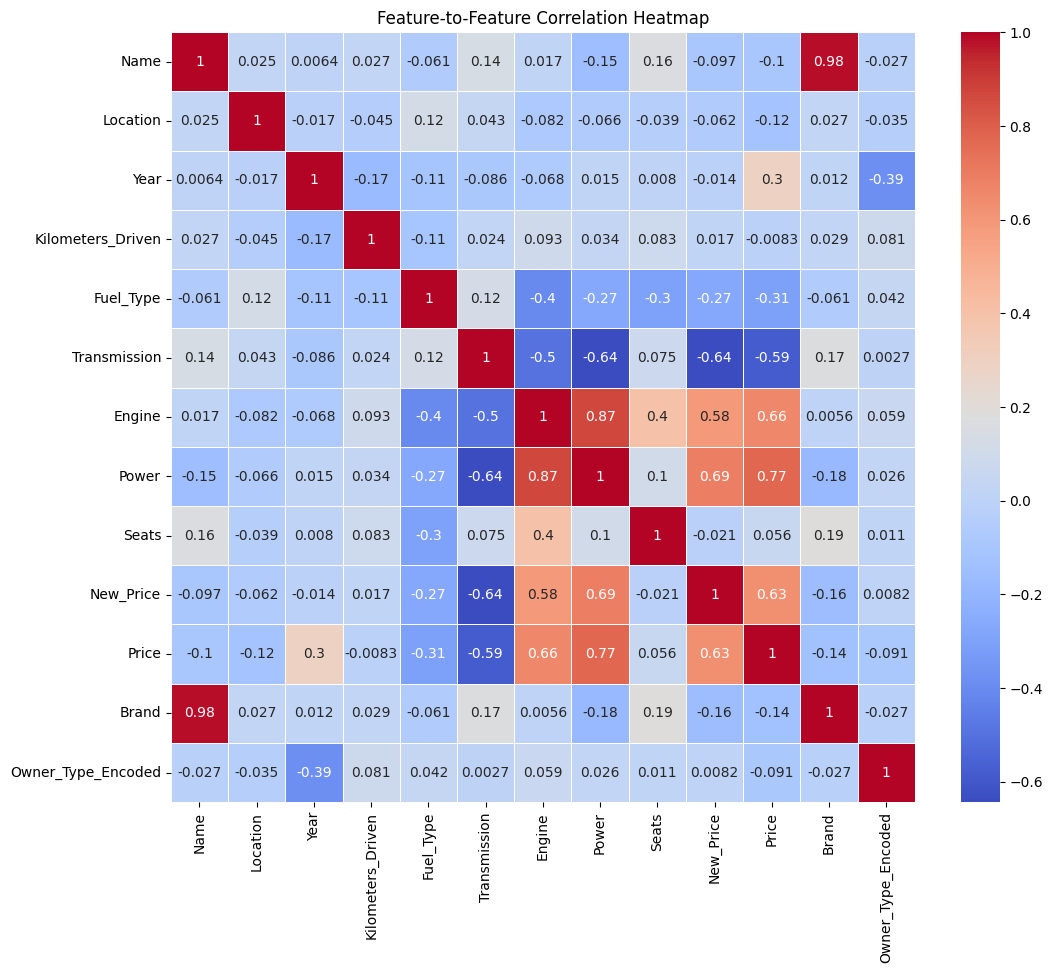

In [17]:
corr_matrix = df_train.corr()

plt.figure(figsize=(12,10))
sns.heatmap(
    corr_matrix,
    cmap='coolwarm',
    annot=True,
    linewidths=0.5
)
plt.title('Feature-to-Feature Correlation Heatmap')
plt.show()

Manual Feature Selection

In [18]:
manual_features = ['Name', 'Year', 'Kilometers_Driven', 'Fuel_Type', 'Transmission', 'Engine', 'Power', 'New_Price', 'Owner_Type_Encoded']

Auotmated Feature Selection (ANOVA)

In [19]:
anova_selector_u = SelectKBest(score_func=f_regression, k=9)
anova_selector_u.fit(X_train_u, y_train_u)
X_train_anova_u = anova_selector_u.transform(X_train_u)
X_val_anova_u = anova_selector_u.transform(X_val_u)

anova_selector_c = SelectKBest(score_func=f_regression, k=9)
anova_selector_c.fit(X_train_c, y_train_c)
X_train_anova_c = anova_selector_c.transform(X_train_c)
X_val_anova_c = anova_selector_c.transform(X_val_c)

print("1. Manual Feature Selection (9 features we chose):")
print(", ".join(manual_features))
print(f"Total: {len(manual_features)} features")

print("\n2. ANOVA Feature Selection (Top 9 features chosen automatically):")

# For unclipped dataset
selected_features_u = X_full_u.columns[anova_selector_u.get_support()].tolist()
print("Unclipped dataset - Top 9 ANOVA features:")
print(", ".join(selected_features_u))
print(f"Total: {len(selected_features_u)} features")

# For clipped dataset
selected_features_c = X_full_c.columns[anova_selector_c.get_support()].tolist()
print("\nClipped dataset - Top 9 ANOVA features:")
print(", ".join(selected_features_c))
print(f"Total: {len(selected_features_c)} features")

1. Manual Feature Selection (9 features we chose):
Name, Year, Kilometers_Driven, Fuel_Type, Transmission, Engine, Power, New_Price, Owner_Type_Encoded
Total: 9 features

2. ANOVA Feature Selection (Top 9 features chosen automatically):
Unclipped dataset - Top 9 ANOVA features:
Location, Year, Fuel_Type, Transmission, Engine, Power, New_Price, Brand, Owner_Type_Encoded
Total: 9 features

Clipped dataset - Top 9 ANOVA features:
Location, Year, Kilometers_Driven, Fuel_Type, Transmission, Engine, Power, New_Price, Brand
Total: 9 features


Models and Hyperparameters

In [20]:
models = {
    "LinearRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("lr", LinearRegression())
    ]),

    "PolynomialRegression": Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(include_bias=False)),
        ("lr", LinearRegression())
    ]),

    "PolynomialRidge": Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(include_bias=False)),
        ("ridge", Ridge())
    ]),

    "PolynomialLasso": Pipeline([
        ("scaler", StandardScaler()),
        ("poly", PolynomialFeatures(include_bias=False)),
        ("lasso", Lasso(max_iter=10000))
    ]),


    "DecisionTree": DecisionTreeRegressor(random_state=42),
    "RandomForest": RandomForestRegressor(random_state=42),
    "GradientBoosting": GradientBoostingRegressor(random_state=42)
}


param_grids = {
    "LinearRegression": {},

    "PolynomialRegression": {
        "poly__degree": [2, 3]
    },

    "PolynomialRidge": {
    "poly__degree": [2, 3],
    "ridge__alpha": [0.001, 0.01, 0.1, 1, 10, 100]
    },

    "PolynomialLasso": {
        "poly__degree": [2, 3],
        "lasso__alpha": [0.001, 0.01, 0.1, 1, 10]
    },

    "DecisionTree": {
        "max_depth": [5, 10, 20],
        "min_samples_split": [2, 5, 10, 20],
        "min_samples_leaf": [1, 2, 5, 10]
    },

    "RandomForest": {
        "n_estimators": [50, 100, 200],
        "max_depth": [5, 10, 20],
        "min_samples_leaf": [1, 2, 5]
    },

    "GradientBoosting": {
        "n_estimators": [50, 100, 200],
        "learning_rate": [0.01, 0.05, 0.1, 0.5],
        "max_depth": [2, 3, 5]
    }
}

Training and Evaluation

In [21]:
def evaluate_model(model, X_tr, X_va, y_tr, y_va):
    start = time.time()
    model.fit(X_tr, y_tr)
    preds = model.predict(X_va)
    end = time.time()
    rmse = np.sqrt(mean_squared_error(y_va, preds))
    mae = mean_absolute_error(y_va, preds)
    r2 = r2_score(y_va, preds)

    return {"RMSE": rmse, "MAE": mae, "R2": r2, "Time": end-start}

In [22]:
results = {"manual_unclipped": {}, "anova_unclipped": {}, "manual_clipped": {}, "anova_clipped": {}}
results_test = {"manual_unclipped": {}, "anova_unclipped": {}, "manual_clipped": {}, "anova_clipped": {}}
best_params = {}

for ds in ["unclipped", "clipped"]:
    if ds == "unclipped":
        X_train = X_train_u
        X_val = X_val_u
        y_train = y_train_u
        y_val = y_val_u
        X_test = X_test_u
        y_test = y_test_u
        anova_train = X_train_anova_u
        anova_val = X_val_anova_u
        anova_test = anova_selector_u.transform(X_test)
        manual_train = X_train[manual_features]
        manual_val = X_val[manual_features]
        manual_test = X_test[manual_features]
    else:
        X_train = X_train_c
        X_val = X_val_c
        y_train = y_train_c
        y_val = y_val_c
        X_test = X_test_c
        y_test = y_test_c
        anova_train = X_train_anova_c
        anova_val = X_val_anova_c
        anova_test = anova_selector_c.transform(X_test)
        manual_train = X_train[manual_features]
        manual_val = X_val[manual_features]
        manual_test = X_test[manual_features]

    for name, model in models.items():
        params = param_grids[name]
        grid = GridSearchCV(model, params, cv=5, scoring='neg_root_mean_squared_error', n_jobs=-1)

        #Manual
        grid.fit(manual_train, y_train)
        best_model = grid.best_estimator_
        results[f"manual_{ds}"][name] = evaluate_model(best_model, manual_train, manual_val, y_train, y_val)
        best_params[f"{name}_manual_{ds}"] = grid.best_params_

        preds_test = best_model.predict(manual_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
        mae_test = mean_absolute_error(y_test, preds_test)
        r2_test = r2_score(y_test, preds_test)
        results_test[f"manual_{ds}"][name] = {"RMSE": rmse_test, "MAE": mae_test, "R2": r2_test, "Time": results[f"manual_{ds}"][name]["Time"]}

        #ANOVA
        grid = GridSearchCV(model, params, cv=3, scoring='neg_root_mean_squared_error', n_jobs=-1)
        grid.fit(anova_train, y_train)
        best_model = grid.best_estimator_
        results[f"anova_{ds}"][name] = evaluate_model(best_model, anova_train, anova_val, y_train, y_val)
        best_params[f"{name}_anova_{ds}"] = grid.best_params_

        preds_test = best_model.predict(anova_test)
        rmse_test = np.sqrt(mean_squared_error(y_test, preds_test))
        mae_test = mean_absolute_error(y_test, preds_test)
        r2_test = r2_score(y_test, preds_test)
        results_test[f"anova_{ds}"][name] = {"RMSE": rmse_test, "MAE": mae_test, "R2": r2_test, "Time": results[f"anova_{ds}"][name]["Time"]}

Results

In [23]:
manual_u_df = pd.DataFrame(results["manual_unclipped"]).T
anova_u_df = pd.DataFrame(results["anova_unclipped"]).T

manual_c_df = pd.DataFrame(results["manual_clipped"]).T
anova_c_df = pd.DataFrame(results["anova_clipped"]).T

manual_u_df_test = pd.DataFrame(results_test["manual_unclipped"]).T
anova_u_df_test = pd.DataFrame(results_test["anova_unclipped"]).T

manual_c_df_test = pd.DataFrame(results_test["manual_clipped"]).T
anova_c_df_test = pd.DataFrame(results_test["anova_clipped"]).T

best_manual_u = manual_u_df['RMSE'].idxmin()
best_anova_u = anova_u_df['RMSE'].idxmin()

best_manual_c = manual_c_df['RMSE'].idxmin()
best_anova_c = anova_c_df['RMSE'].idxmin()

print("Best Manual Feature Model Unclipped:", best_manual_u, f"(RMSE: {manual_u_df.loc[best_manual_u, 'RMSE']:.4f})")
print("Best ANOVA Feature Model Unclipped:", best_anova_u, f"(RMSE: {anova_u_df.loc[best_anova_u, 'RMSE']:.4f})")
print("Best Manual Feature Model Clipped:", best_manual_c, f"(RMSE: {manual_c_df.loc[best_manual_c, 'RMSE']:.4f})")
print("Best ANOVA Feature Model Clipped:", best_anova_c, f"(RMSE: {anova_c_df.loc[best_anova_c, 'RMSE']:.4f})")
print("\nBest parameters:")

for key, val in best_params.items():
    print(f"{key}: {val}")

print("\nManual Features Unclipped Results (Val):")
display(manual_u_df.round(4))
print("ANOVA Features Unclipped Results (Val):")
display(anova_u_df.round(4))
print("Manual Features Clipped Results (Val):")
display(manual_c_df.round(4))
print("ANOVA Features Clipped Results (Val):")
display(anova_c_df.round(4))

print("Manual Features Unclipped Results (Test):")
display(manual_u_df_test.round(4))
print("ANOVA Features Unclipped Results (Test):")
display(anova_u_df_test.round(4))
print("Manual Features Clipped Results (Test):")
display(manual_c_df_test.round(4))
print("ANOVA Features Clipped Results (Test):")
display(anova_c_df_test.round(4))

Best Manual Feature Model Unclipped: GradientBoosting (RMSE: 4.3519)
Best ANOVA Feature Model Unclipped: RandomForest (RMSE: 4.5109)
Best Manual Feature Model Clipped: GradientBoosting (RMSE: 2.1133)
Best ANOVA Feature Model Clipped: GradientBoosting (RMSE: 2.1204)

Best parameters:
LinearRegression_manual_unclipped: {}
LinearRegression_anova_unclipped: {}
PolynomialRegression_manual_unclipped: {'poly__degree': 2}
PolynomialRegression_anova_unclipped: {'poly__degree': 2}
PolynomialRidge_manual_unclipped: {'poly__degree': 2, 'ridge__alpha': 0.001}
PolynomialRidge_anova_unclipped: {'poly__degree': 3, 'ridge__alpha': 100}
PolynomialLasso_manual_unclipped: {'lasso__alpha': 1, 'poly__degree': 2}
PolynomialLasso_anova_unclipped: {'lasso__alpha': 0.1, 'poly__degree': 3}
DecisionTree_manual_unclipped: {'max_depth': 20, 'min_samples_leaf': 2, 'min_samples_split': 20}
DecisionTree_anova_unclipped: {'max_depth': 10, 'min_samples_leaf': 5, 'min_samples_split': 20}
RandomForest_manual_unclipped: {'

,RMSE,MAE,R2,Time
LinearRegression,6.4647,3.5563,0.6876,0.0044
PolynomialRegression,4.9426,2.4053,0.8174,0.0118
PolynomialRidge,4.9426,2.4053,0.8174,0.0068
PolynomialLasso,5.6505,2.6479,0.7614,0.0102
DecisionTree,5.2965,2.0470,0.7903,0.0105
RandomForest,4.7349,1.6538,0.8324,1.9803
GradientBoosting,4.3519,1.6848,0.8584,0.6150


ANOVA Features Unclipped Results (Val):


,RMSE,MAE,R2,Time
LinearRegression,6.4310,3.5548,0.6909,0.0024
PolynomialRegression,4.9698,2.3684,0.8154,0.0105
PolynomialRidge,4.5215,2.0675,0.8472,0.0211
PolynomialLasso,4.9110,2.1007,0.8197,0.1382
DecisionTree,5.3730,2.1230,0.7842,0.0130
RandomForest,4.5109,1.6015,0.8479,1.5806
GradientBoosting,4.6171,1.5836,0.8407,0.6886


Manual Features Clipped Results (Val):


,RMSE,MAE,R2,Time
LinearRegression,3.4510,2.3652,0.8144,0.0037
PolynomialRegression,2.6445,1.6314,0.8910,0.0470
PolynomialRidge,2.5912,1.6142,0.8954,0.0142
PolynomialLasso,2.5429,1.5929,0.8992,0.6613
DecisionTree,2.7750,1.4504,0.8800,0.0092
RandomForest,2.2118,1.1844,0.9238,1.9376
GradientBoosting,2.1133,1.2346,0.9304,0.6104


ANOVA Features Clipped Results (Val):


,RMSE,MAE,R2,Time
LinearRegression,3.4271,2.3475,0.8170,0.0019
PolynomialRegression,2.6446,1.5961,0.8910,0.0455
PolynomialRidge,2.5851,1.5781,0.8959,0.0113
PolynomialLasso,2.5503,1.5610,0.8986,0.7980
DecisionTree,2.8471,1.4882,0.8737,0.0132
RandomForest,2.2005,1.1740,0.9245,0.4781
GradientBoosting,2.1204,1.2093,0.9299,0.5665


Manual Features Unclipped Results (Test):


,RMSE,MAE,R2,Time
LinearRegression,5.8758,3.5212,0.7073,0.0044
PolynomialRegression,3.9413,2.2732,0.8683,0.0118
PolynomialRidge,3.9413,2.2732,0.8683,0.0068
PolynomialLasso,4.7569,2.5738,0.8081,0.0102
DecisionTree,4.0586,1.8717,0.8603,0.0105
RandomForest,3.1809,1.4863,0.9142,1.9803
GradientBoosting,2.9697,1.5925,0.9252,0.6150


ANOVA Features Unclipped Results (Test):


,RMSE,MAE,R2,Time
LinearRegression,5.8298,3.4925,0.7118,0.0024
PolynomialRegression,3.9364,2.2179,0.8686,0.0105
PolynomialRidge,4.0685,1.9971,0.8596,0.0211
PolynomialLasso,4.0753,1.9798,0.8592,0.1382
DecisionTree,4.2569,2.0032,0.8463,0.0130
RandomForest,3.2794,1.5409,0.9088,1.5806
GradientBoosting,3.1285,1.4166,0.9170,0.6886


Manual Features Clipped Results (Test):


,RMSE,MAE,R2,Time
LinearRegression,3.2880,2.3263,0.8107,0.0037
PolynomialRegression,2.4190,1.5870,0.8976,0.0470
PolynomialRidge,2.3872,1.5716,0.9002,0.0142
PolynomialLasso,2.3410,1.5459,0.9041,0.6613
DecisionTree,2.4020,1.3747,0.8990,0.0092
RandomForest,1.8842,1.1156,0.9378,1.9376
GradientBoosting,1.8015,1.1827,0.9432,0.6104


ANOVA Features Clipped Results (Test):


,RMSE,MAE,R2,Time
LinearRegression,3.2575,2.2913,0.8142,0.0019
PolynomialRegression,2.3468,1.5545,0.9036,0.0455
PolynomialRidge,2.3189,1.5337,0.9059,0.0113
PolynomialLasso,2.3088,1.5021,0.9067,0.7980
DecisionTree,2.5757,1.4772,0.8839,0.0132
RandomForest,1.9238,1.1109,0.9352,0.4781
GradientBoosting,1.6756,1.0839,0.9508,0.5665


### Enhanced Model Analysis

The second trial demonstrates a clear improvement in model generalisation due to enhanced data cleaning, feature engineering, and outlier clipping. Across both manual and ANOVA-selected feature sets, validation and test metrics remain closely aligned, indicating effective control of both bias and variance.

Unclipped feature sets show moderate performance gains over baseline models; however, slight discrepancies between validation and test errors suggest residual sensitivity to extreme values. This effect is most noticeable in higher-capacity models such as polynomial regressions and tree-based methods, where variance remains elevated in the presence of outliers.

Outlier clipping substantially reduces error across all models, leading to consistent improvements in RMSE and R-squared on both validation and test sets. The reduction in the performance gap between validation and test results indicates that variance has been effectively controlled without introducing underfitting. Linear models benefit from reduced noise, while regularised polynomial models—particularly Polynomial Lasso and Ridge—achieve strong generalisation by balancing increased model capacity with coefficient shrinkage.

Ensemble methods, especially Random Forest and Gradient Boosting, achieve the highest predictive performance after clipping, with minimal divergence between validation and test metrics. This stability suggests that these models successfully leverage increased complexity while avoiding overfitting. No models exhibit the uniformly high errors characteristic of underfitting, and no significant overfitting is observed in the clipped feature configurations.

Overall, Trial 2 confirms that systematic feature engineering and outlier treatment significantly enhance model robustness, resulting in improved generalisation and a well-balanced bias–variance trade-off across all evaluated approaches.


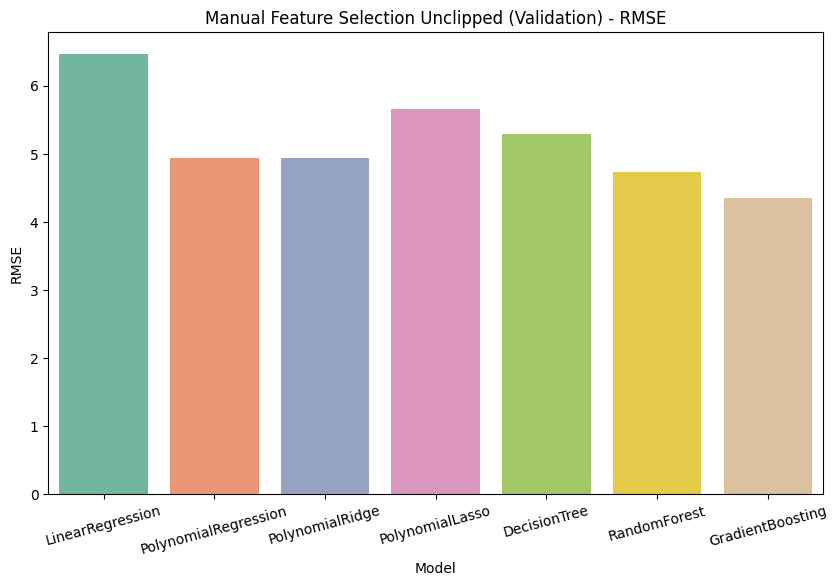

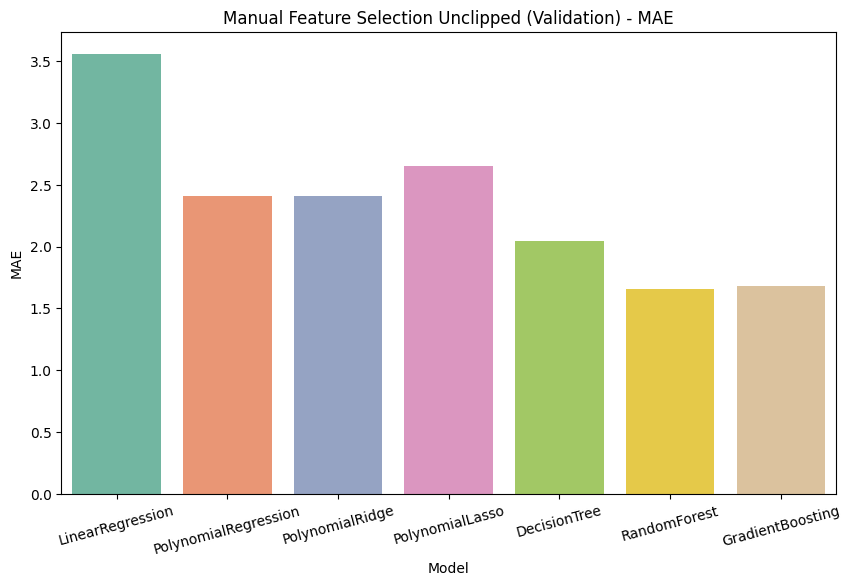

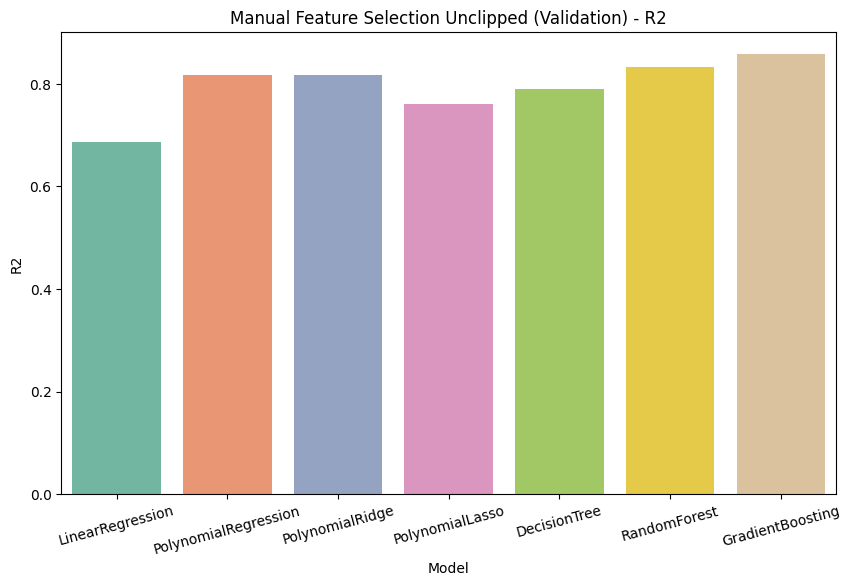

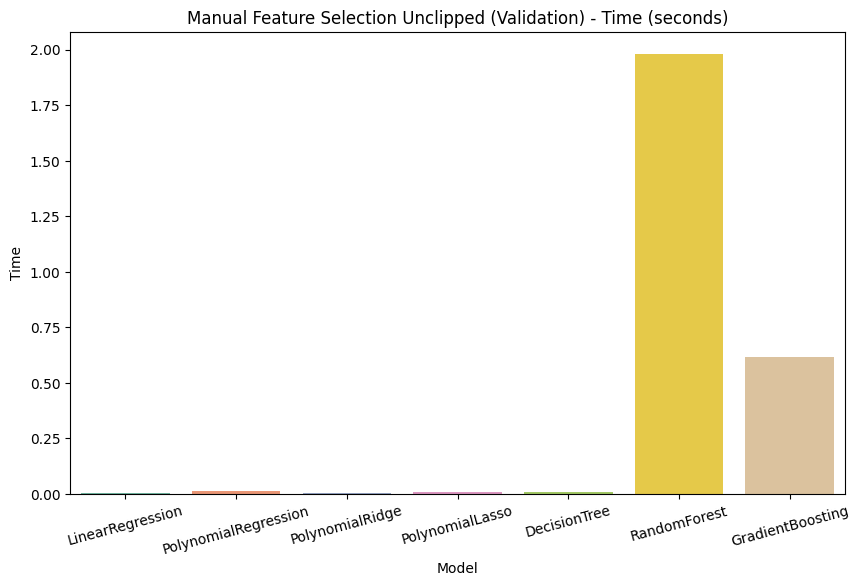

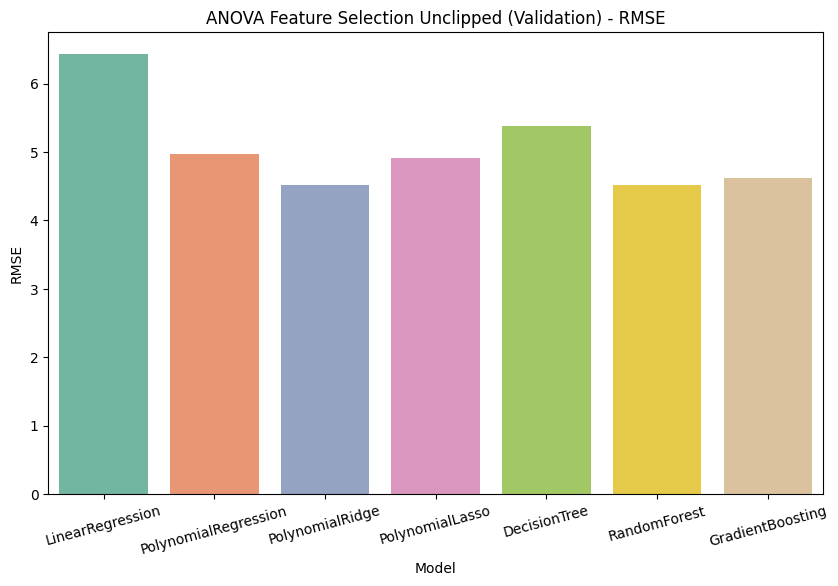

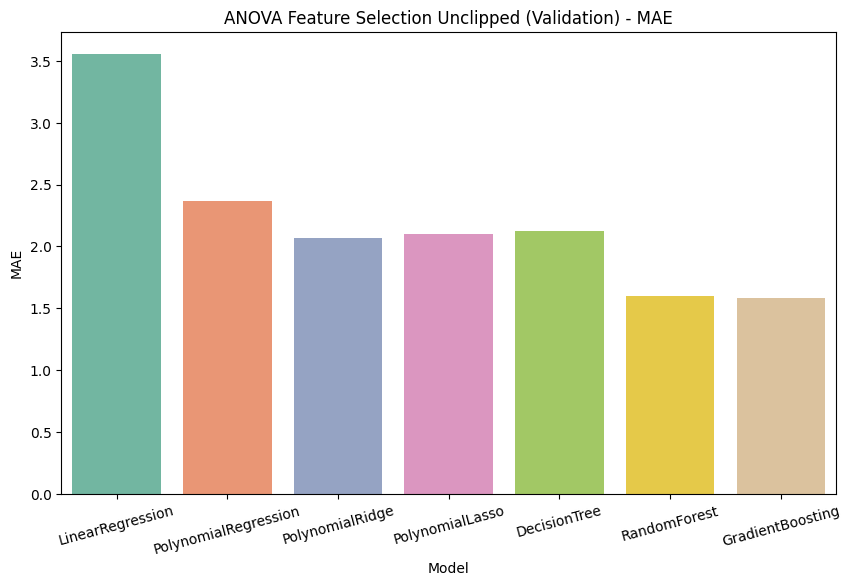

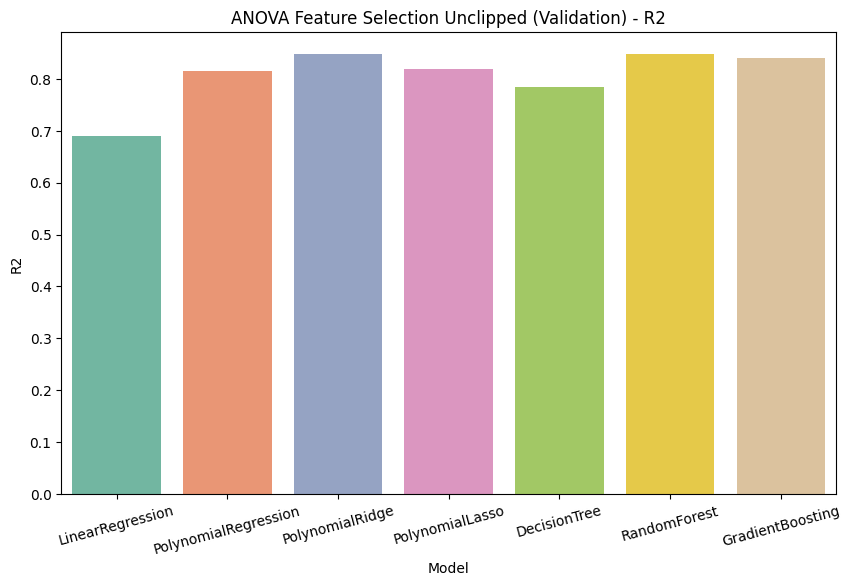

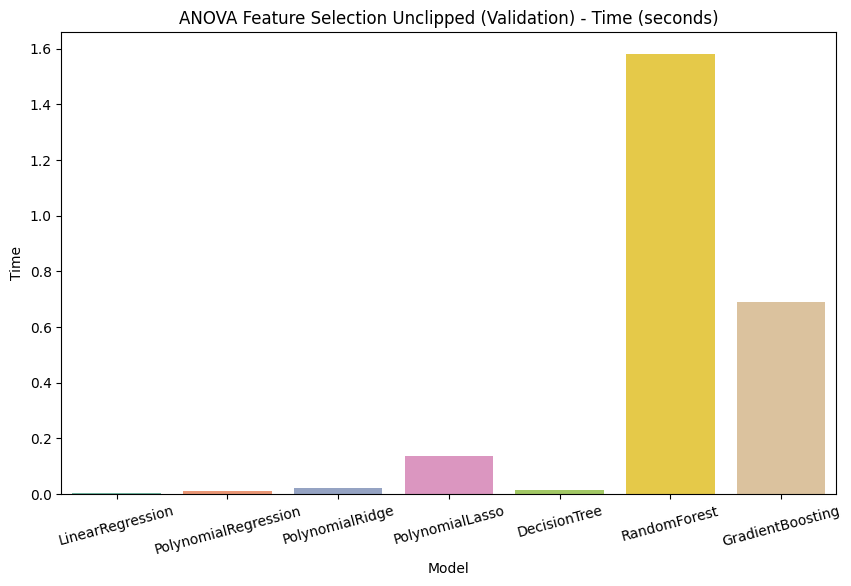

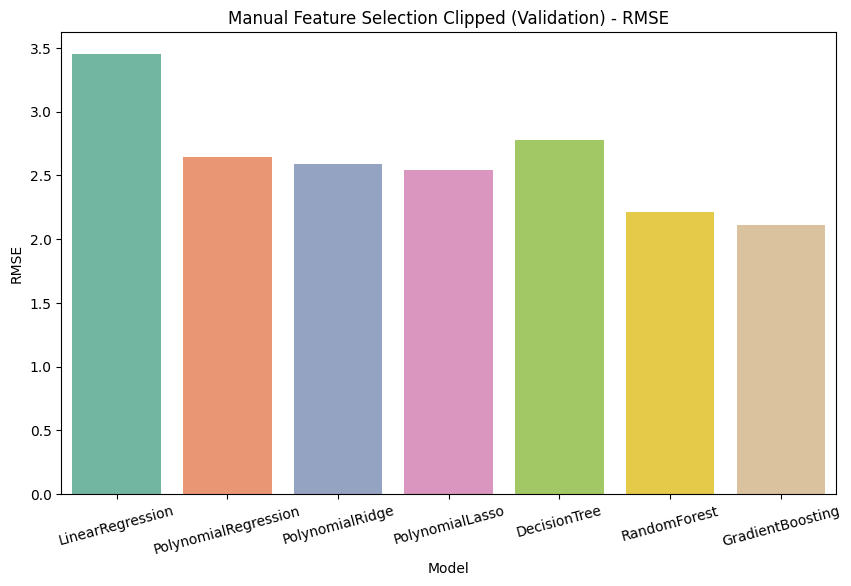

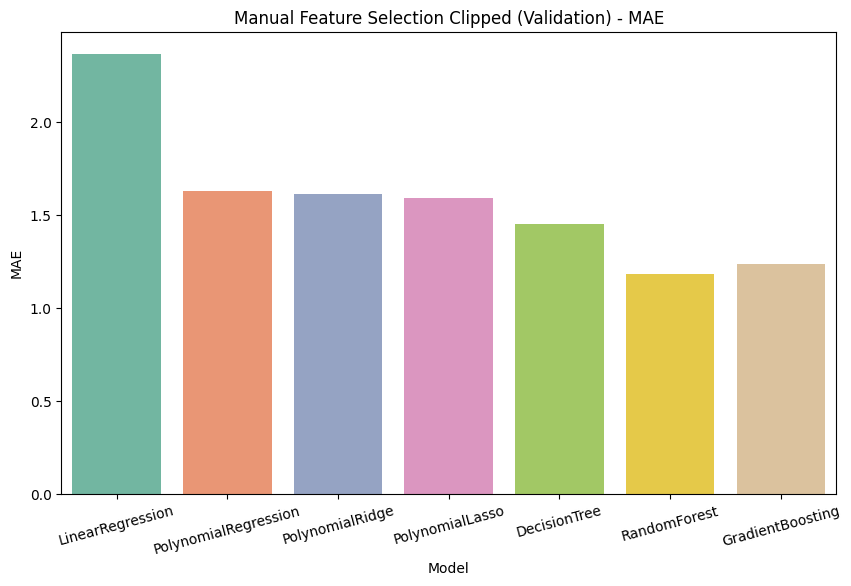

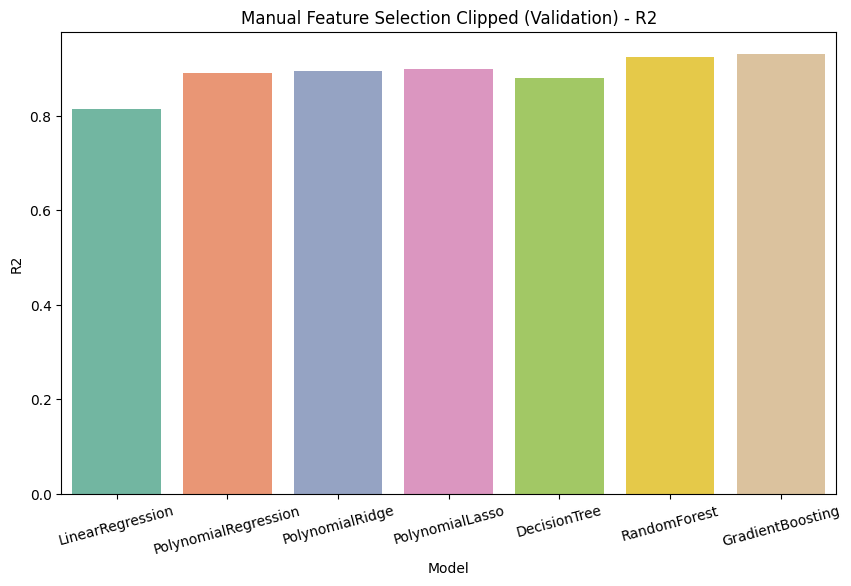

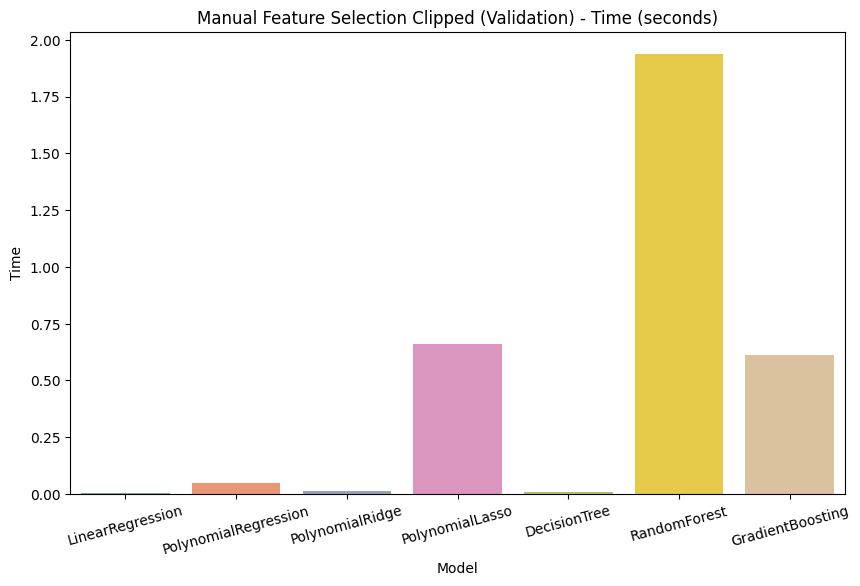

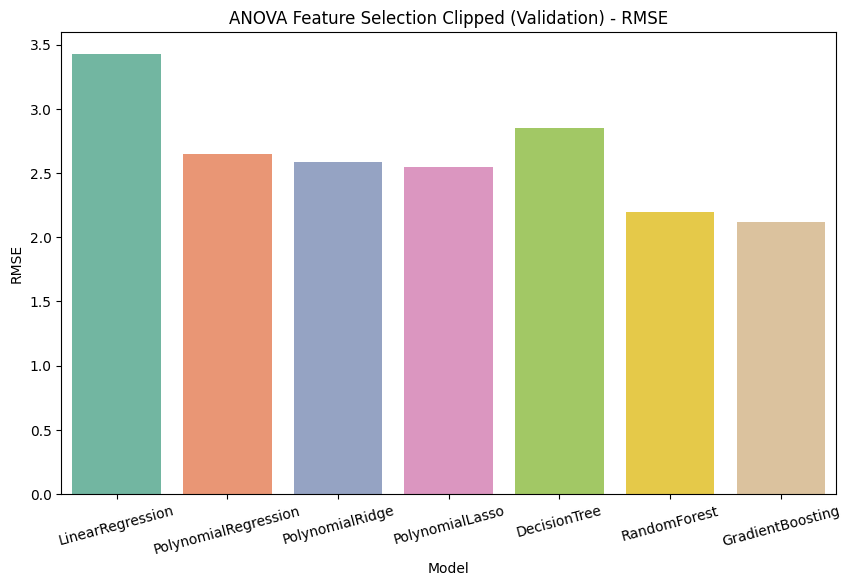

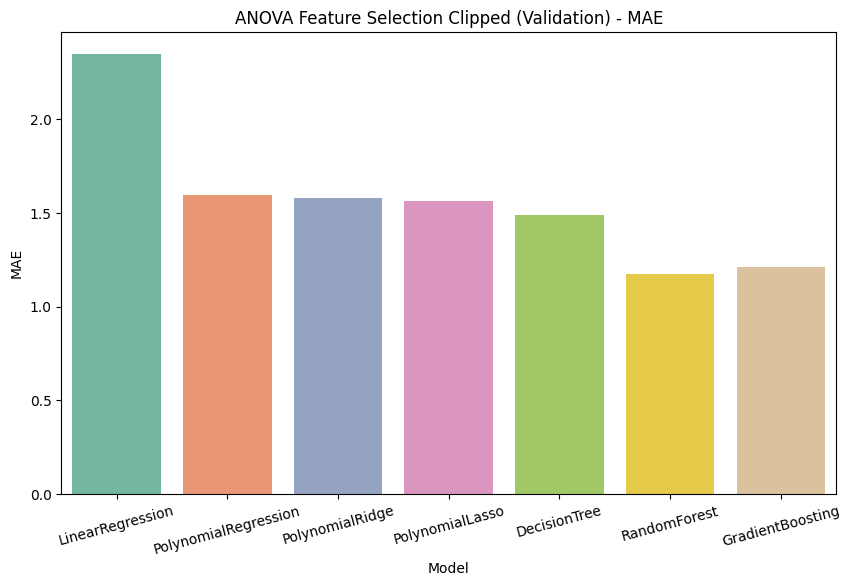

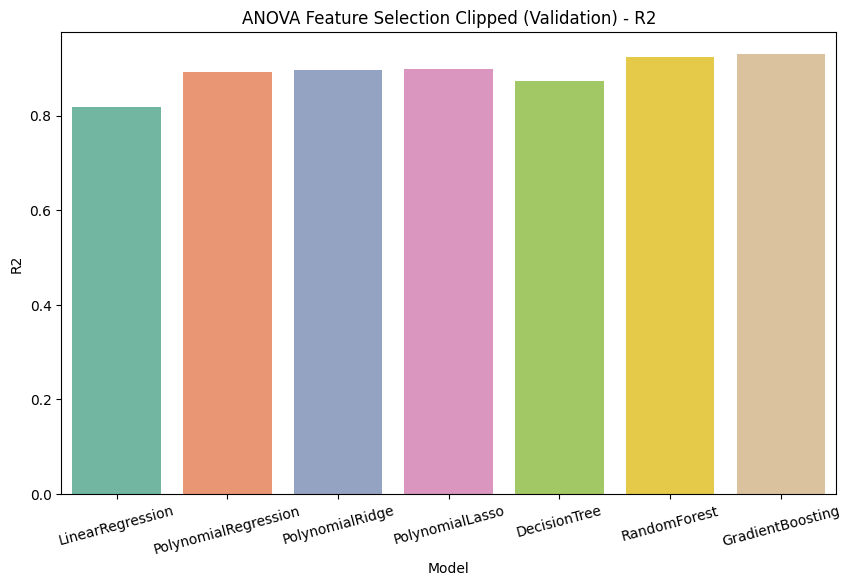

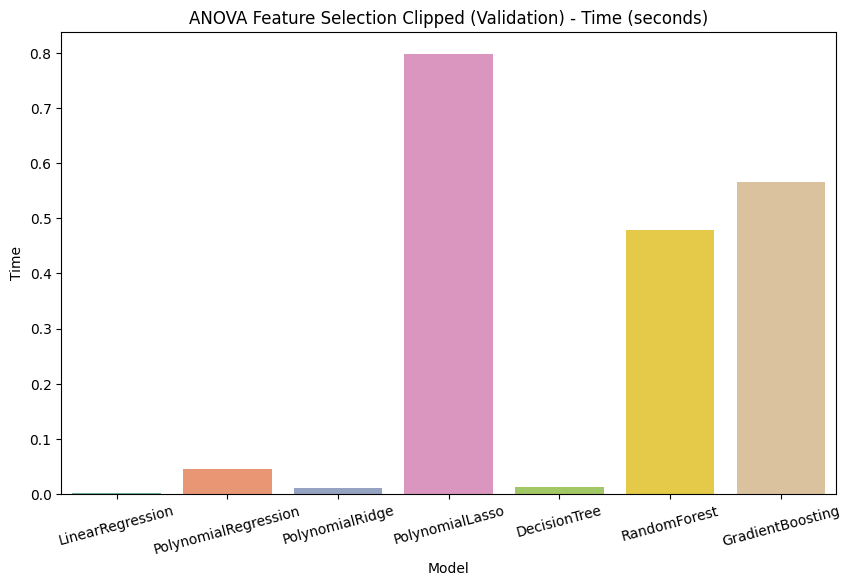

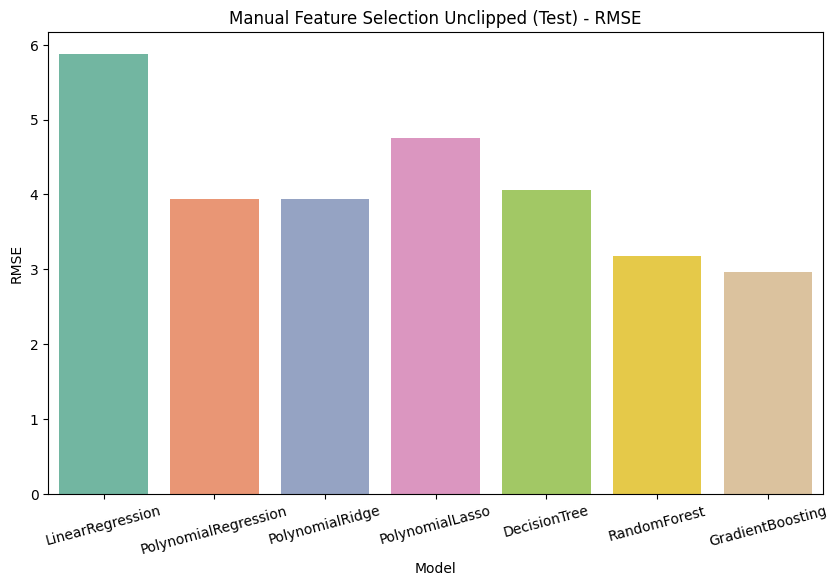

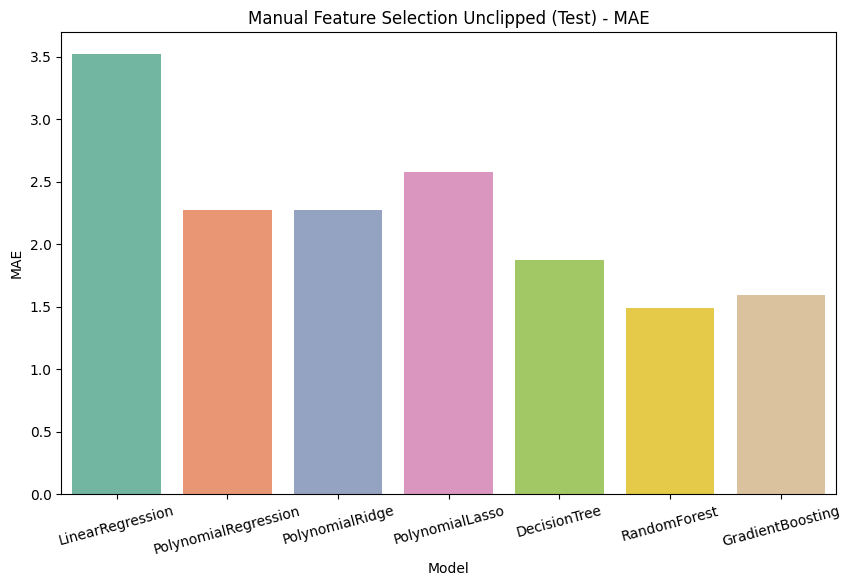

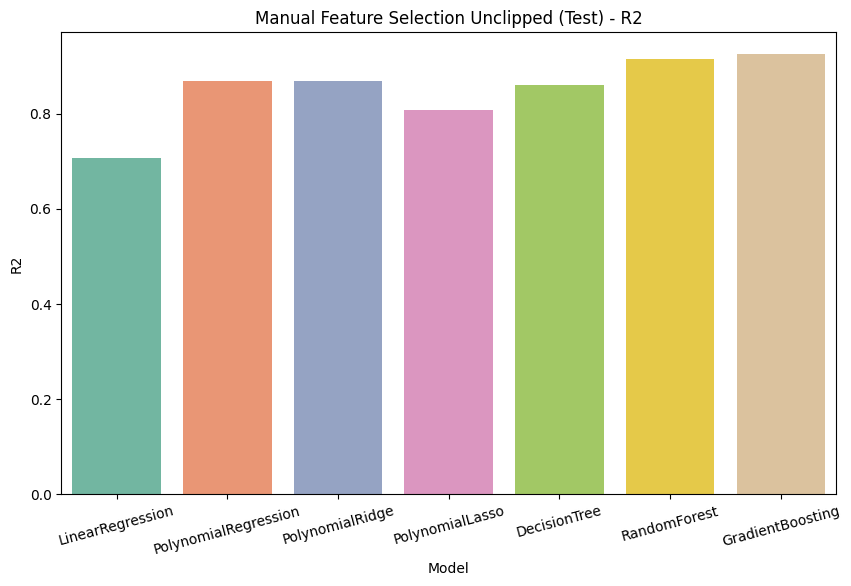

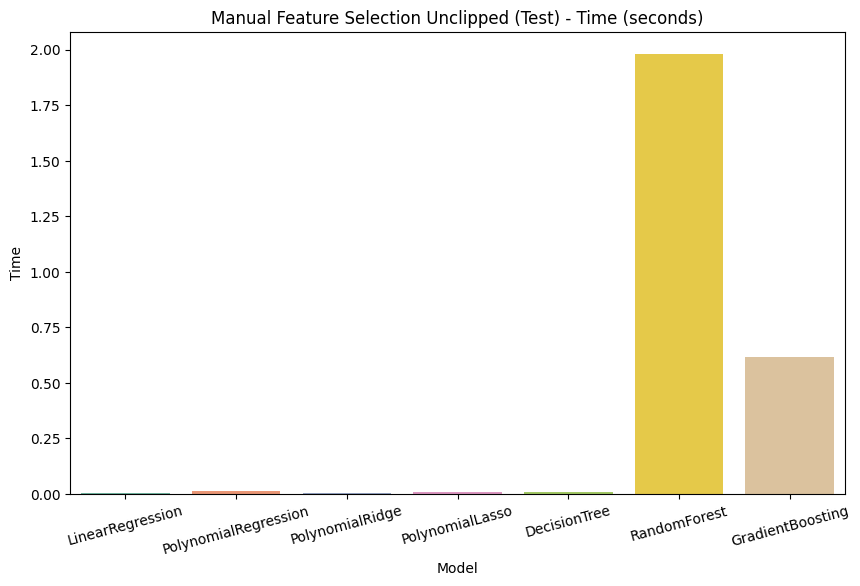

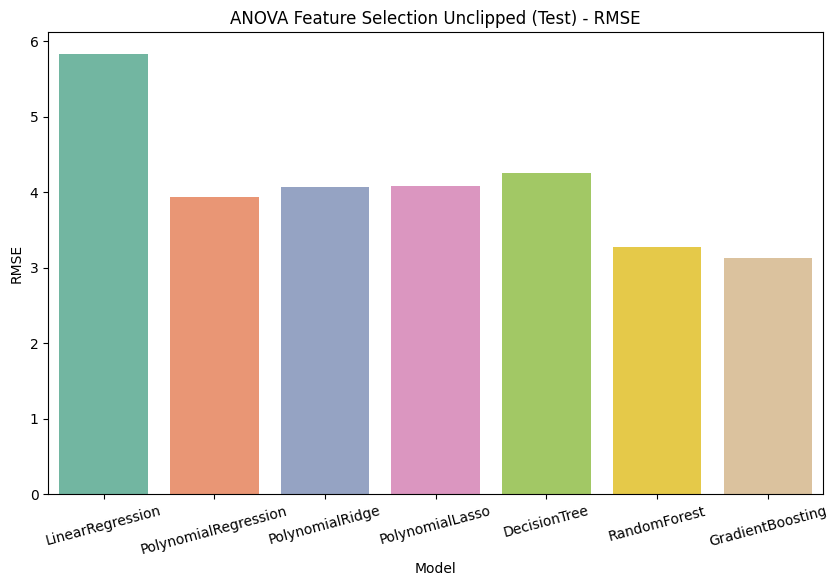

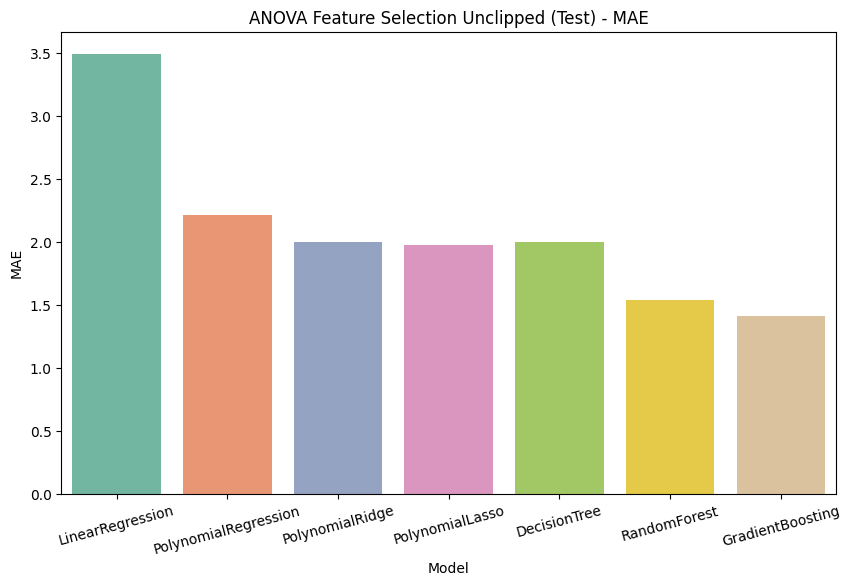

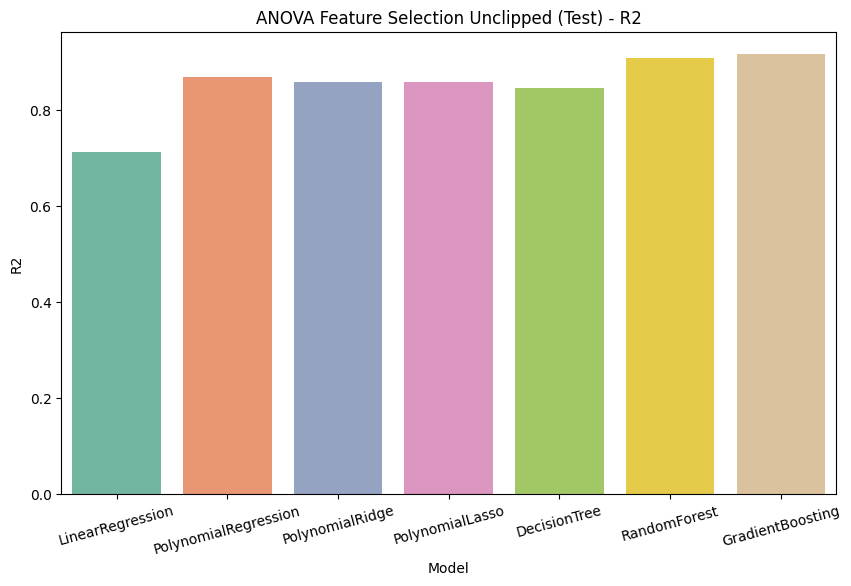

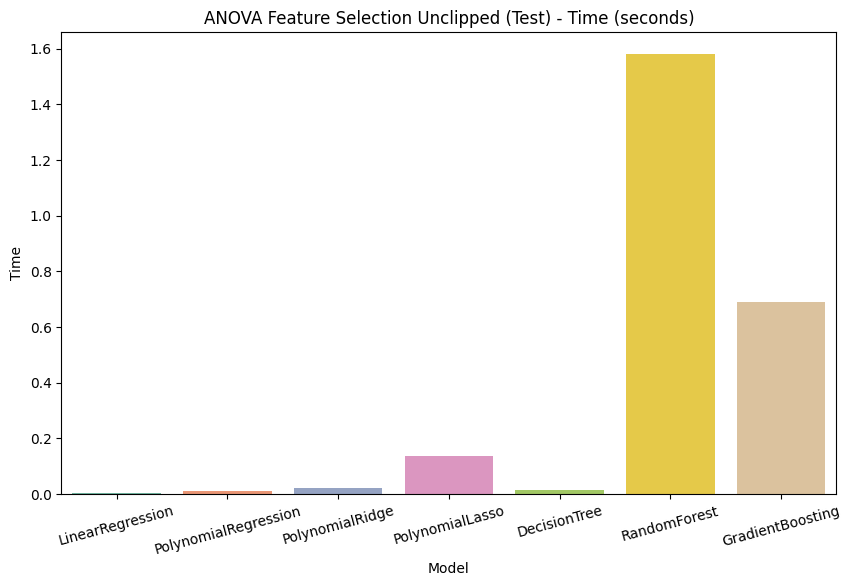

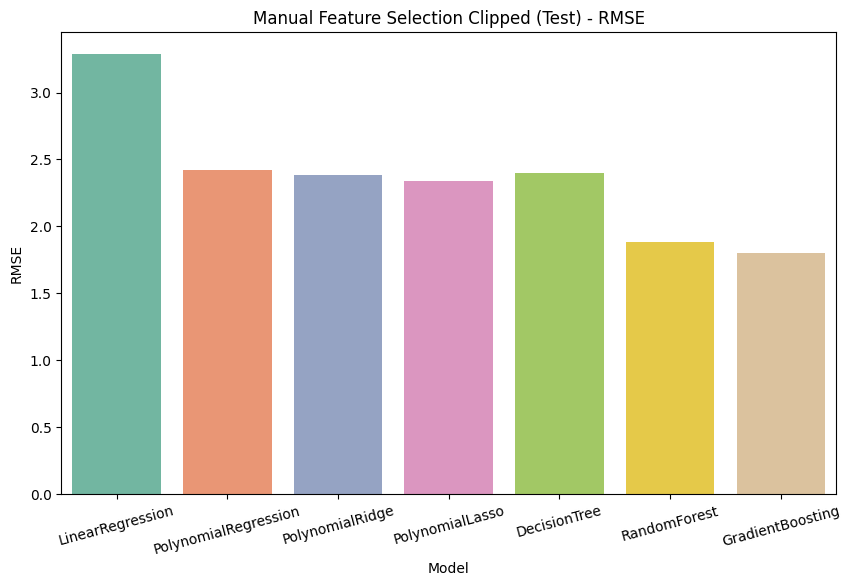

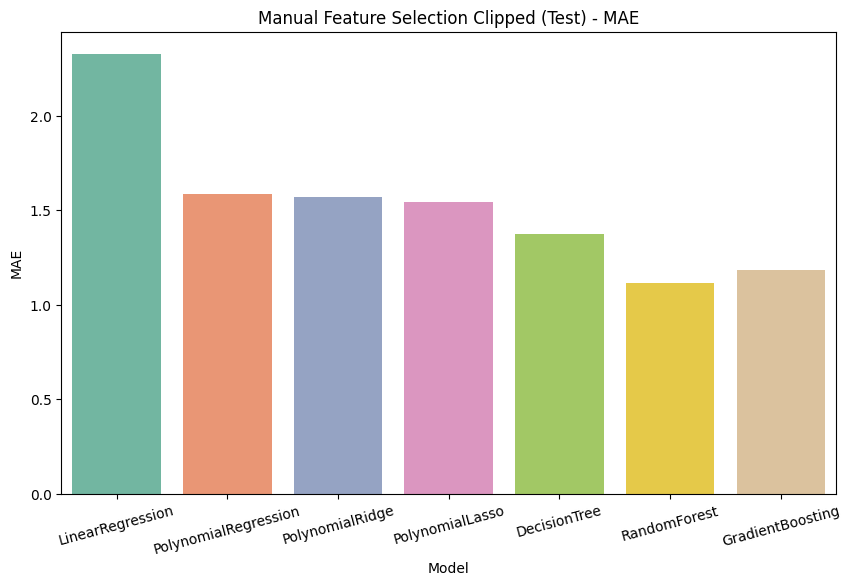

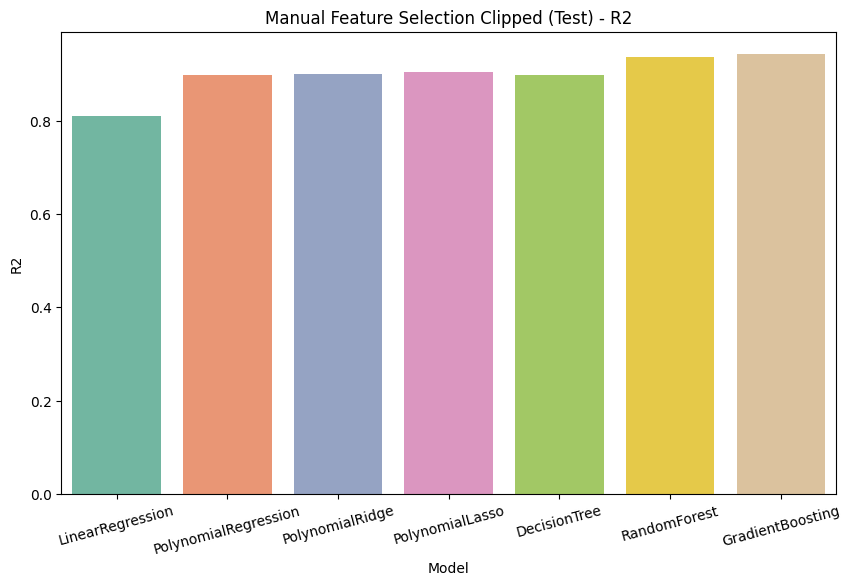

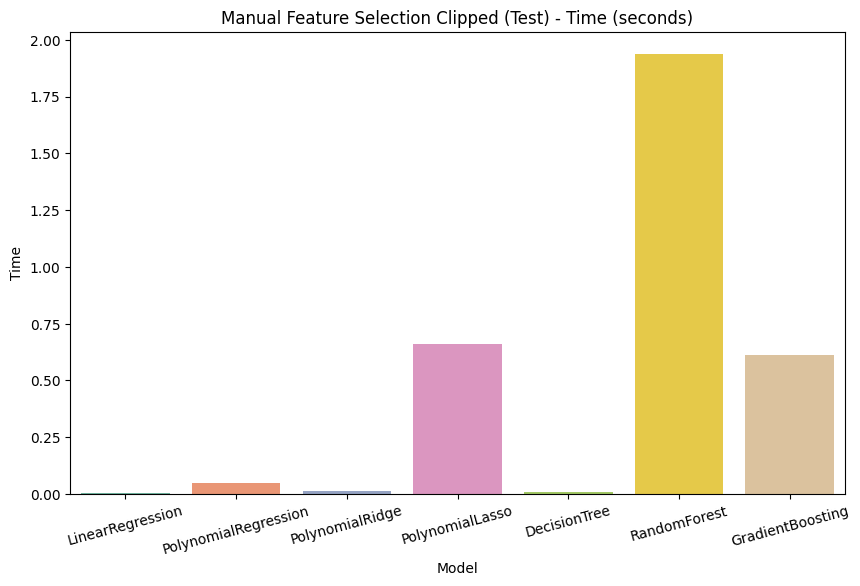

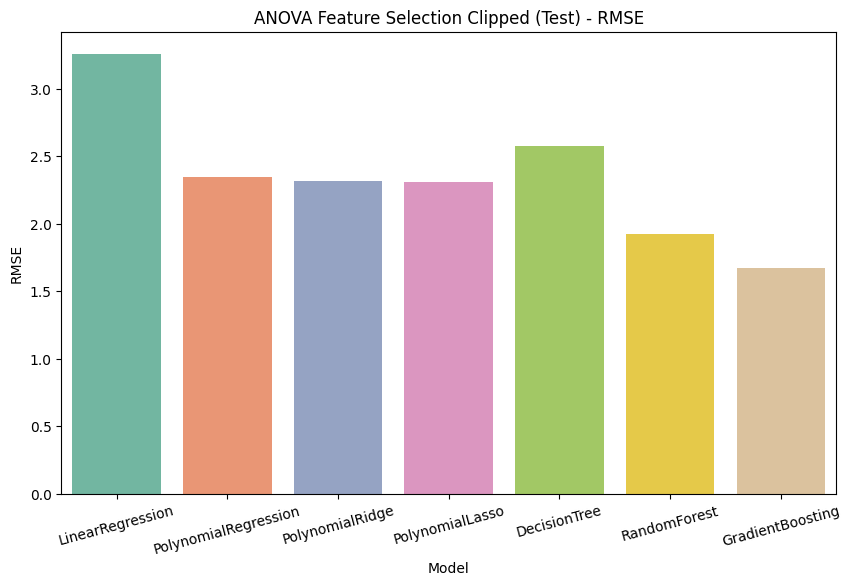

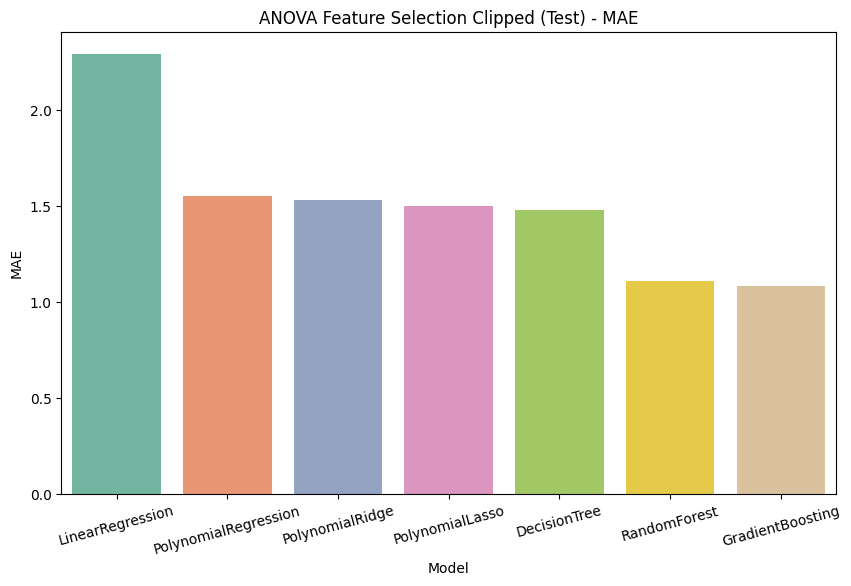

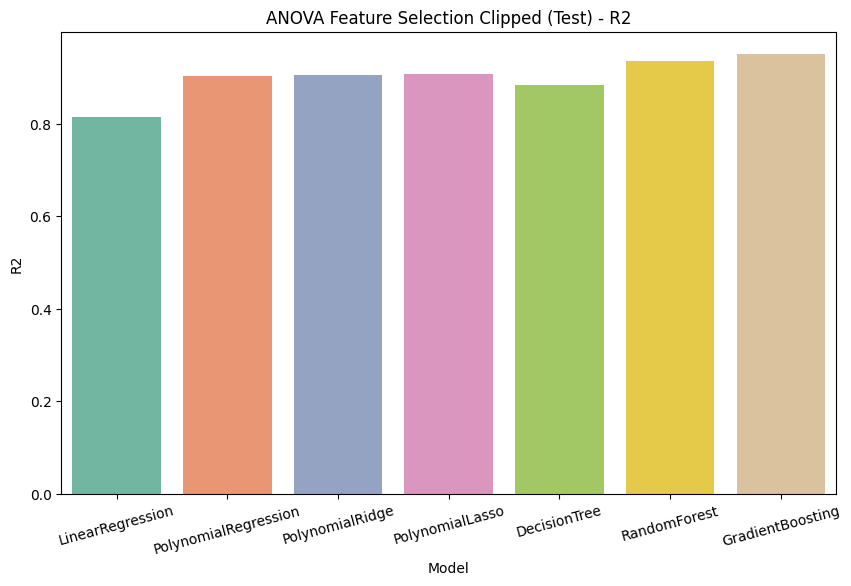

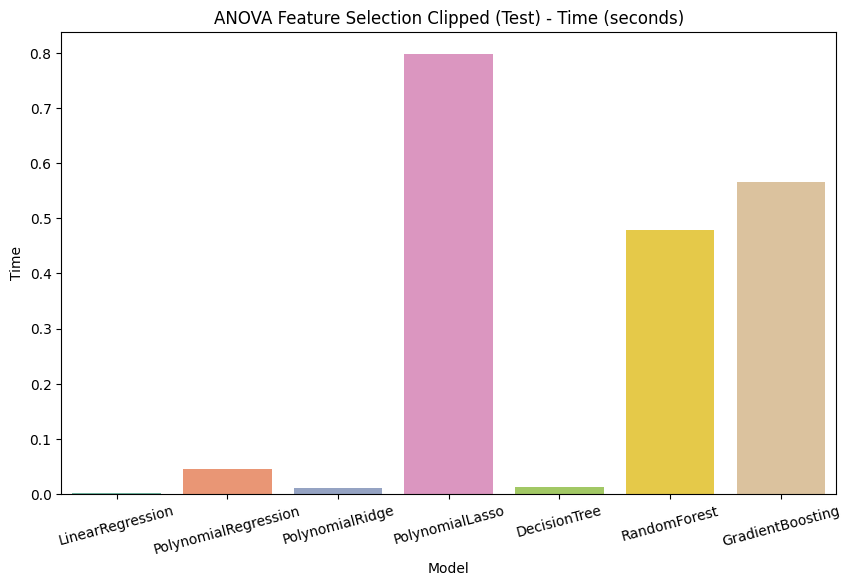

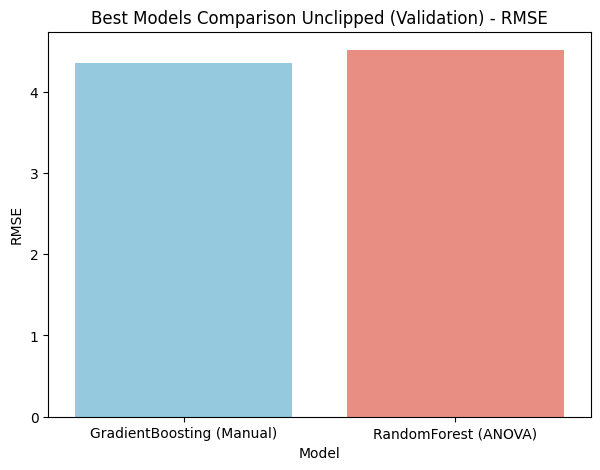

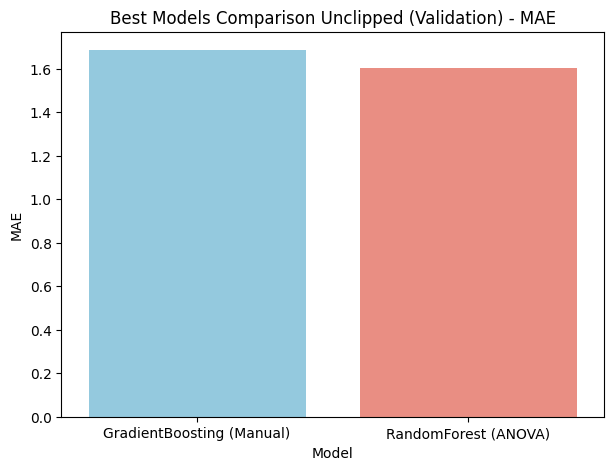

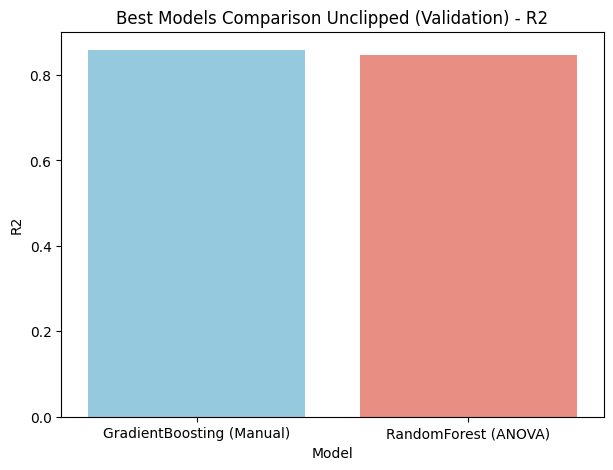

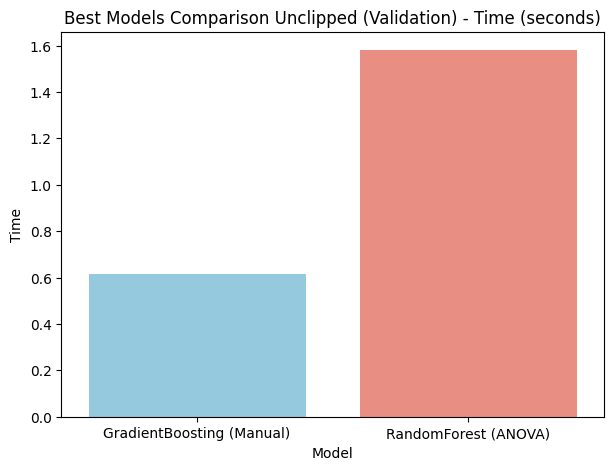

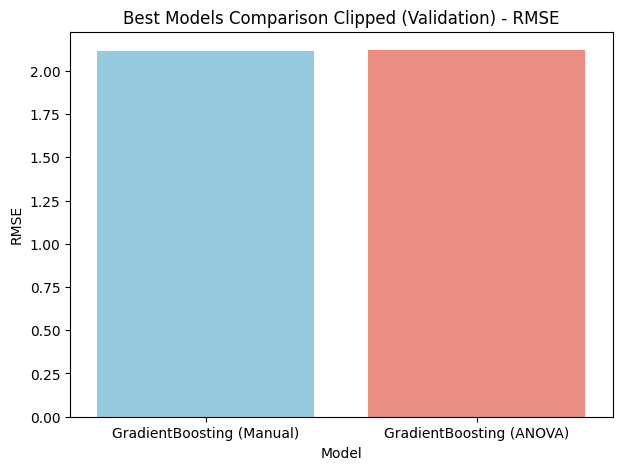

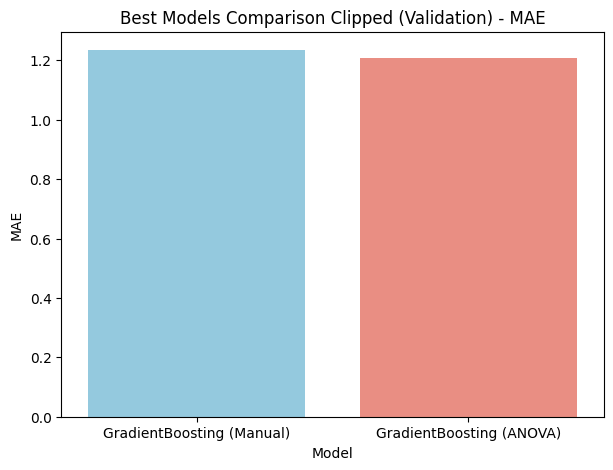

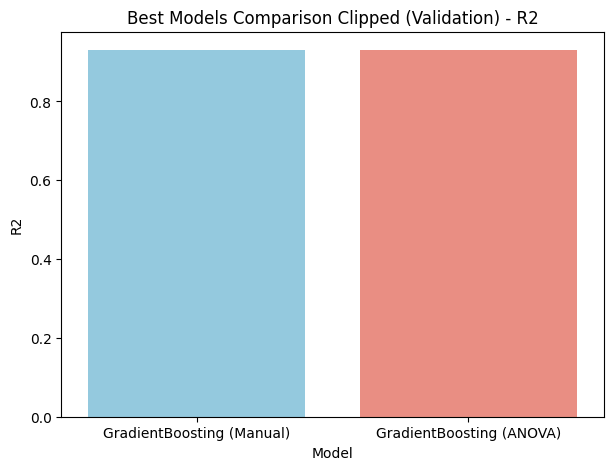

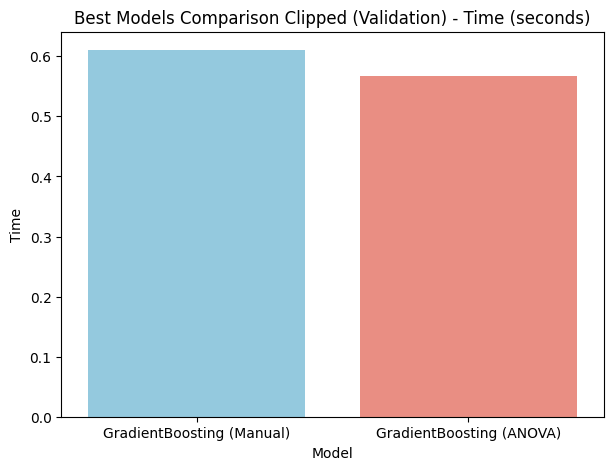

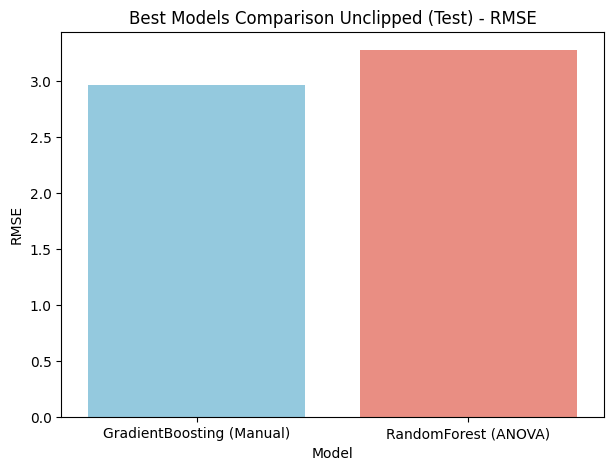

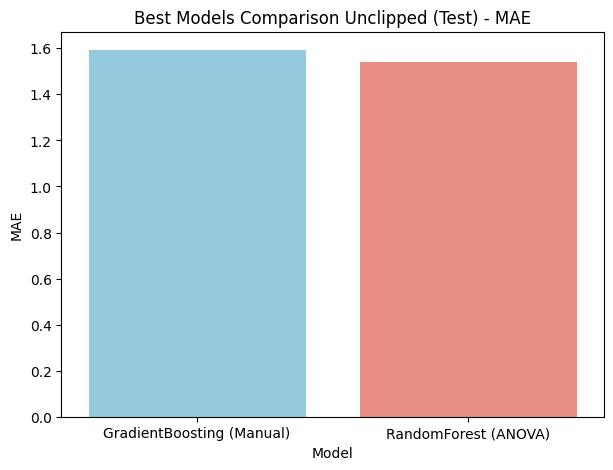

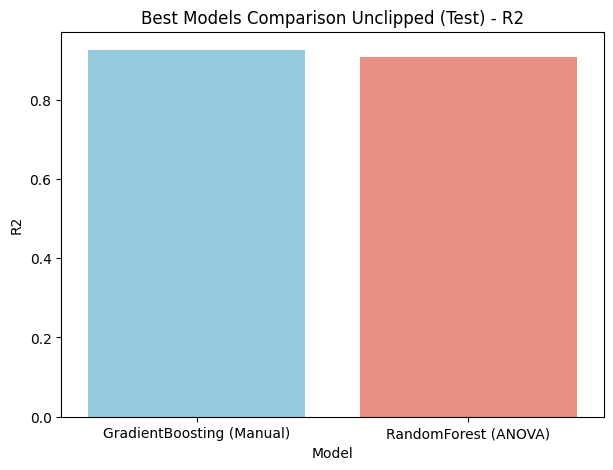

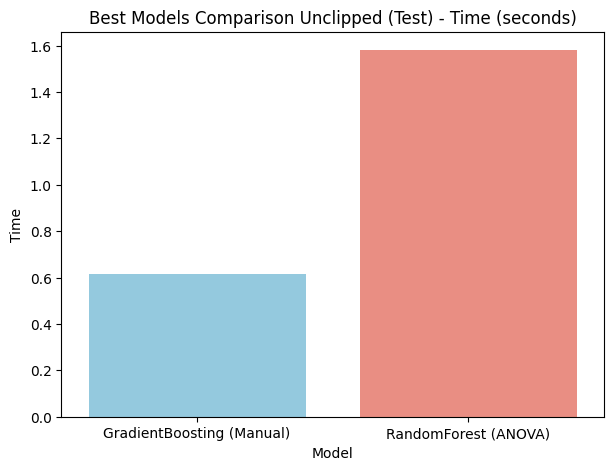

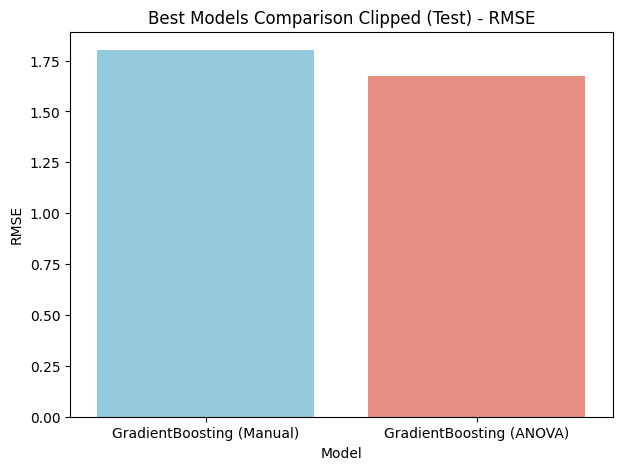

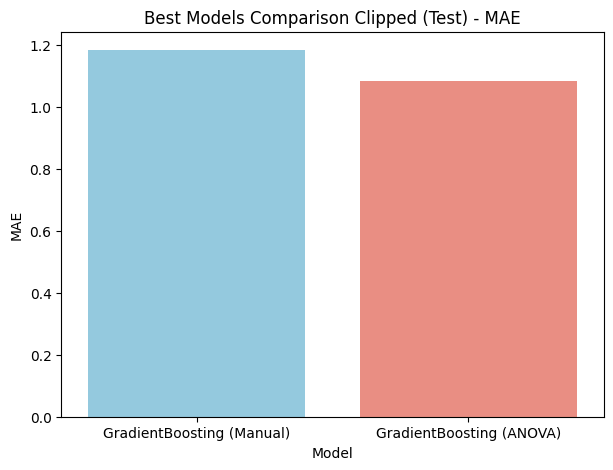

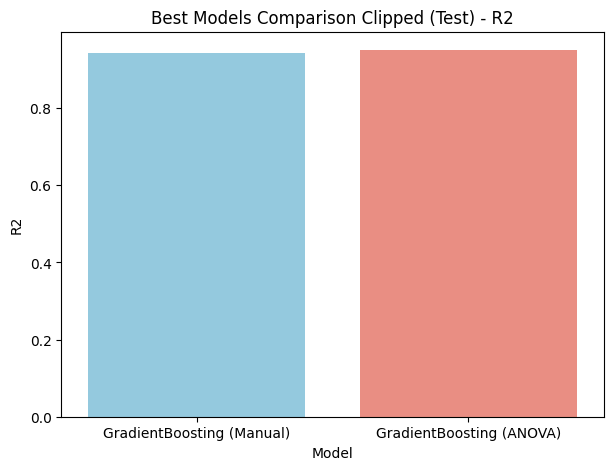

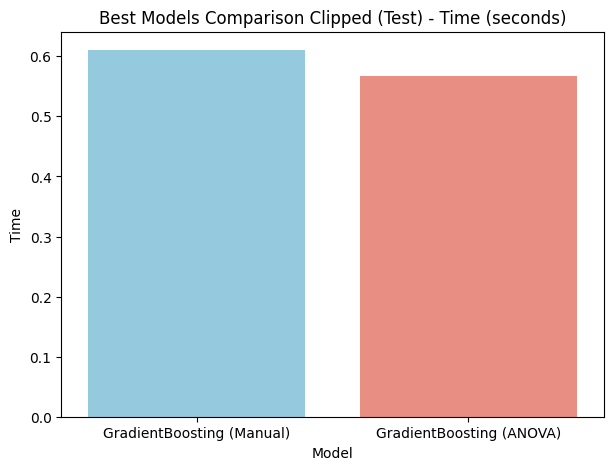

In [24]:
metrics = ['RMSE', 'MAE', 'R2', 'Time']
colors = sns.color_palette("Set2", len(manual_u_df))

for metric in metrics:
    plt.figure(figsize=(10,6))
    sns.barplot(x=manual_u_df.index, y=manual_u_df[metric], palette=colors)
    plt.title(f'Manual Feature Selection Unclipped (Validation) - {metric}' + (" (seconds)" if metric=="Time" else ""))
    plt.xlabel("Model")
    plt.xticks(rotation=15)
    plt.show()

for metric in metrics:
    plt.figure(figsize=(10,6))
    sns.barplot(x=anova_u_df.index, y=anova_u_df[metric], palette=colors)
    plt.title(f'ANOVA Feature Selection Unclipped (Validation) - {metric}' + (" (seconds)" if metric=="Time" else ""))
    plt.xlabel("Model")
    plt.xticks(rotation=15)
    plt.show()

for metric in metrics:
    plt.figure(figsize=(10,6))
    sns.barplot(x=manual_c_df.index, y=manual_c_df[metric], palette=colors)
    plt.title(f'Manual Feature Selection Clipped (Validation) - {metric}' + (" (seconds)" if metric=="Time" else ""))
    plt.xlabel("Model")
    plt.xticks(rotation=15)
    plt.show()

for metric in metrics:
    plt.figure(figsize=(10,6))
    sns.barplot(x=anova_c_df.index, y=anova_c_df[metric], palette=colors)
    plt.title(f'ANOVA Feature Selection Clipped (Validation) - {metric}' + (" (seconds)" if metric=="Time" else ""))
    plt.xlabel("Model")
    plt.xticks(rotation=15)
    plt.show()

for metric in metrics:
    plt.figure(figsize=(10,6))
    sns.barplot(x=manual_u_df_test.index, y=manual_u_df_test[metric], palette=colors)
    plt.title(f'Manual Feature Selection Unclipped (Test) - {metric}' + (" (seconds)" if metric=="Time" else ""))
    plt.xlabel("Model")
    plt.xticks(rotation=15)
    plt.show()

for metric in metrics:
    plt.figure(figsize=(10,6))
    sns.barplot(x=anova_u_df_test.index, y=anova_u_df_test[metric], palette=colors)
    plt.title(f'ANOVA Feature Selection Unclipped (Test) - {metric}' + (" (seconds)" if metric=="Time" else ""))
    plt.xlabel("Model")
    plt.xticks(rotation=15)
    plt.show()

for metric in metrics:
    plt.figure(figsize=(10,6))
    sns.barplot(x=manual_c_df_test.index, y=manual_c_df_test[metric], palette=colors)
    plt.title(f'Manual Feature Selection Clipped (Test) - {metric}' + (" (seconds)" if metric=="Time" else ""))
    plt.xlabel("Model")
    plt.xticks(rotation=15)
    plt.show()

for metric in metrics:
    plt.figure(figsize=(10,6))
    sns.barplot(x=anova_c_df_test.index, y=anova_c_df_test[metric], palette=colors)
    plt.title(f'ANOVA Feature Selection Clipped (Test) - {metric}' + (" (seconds)" if metric=="Time" else ""))
    plt.xlabel("Model")
    plt.xticks(rotation=15)
    plt.show()

#Best models comparison
best_manual_metrics_u = manual_u_df.loc[best_manual_u]
best_anova_metrics_u = anova_u_df.loc[best_anova_u]
comparison_u = pd.DataFrame({
    f"{best_manual_u} (Manual)": best_manual_metrics_u,
    f"{best_anova_u} (ANOVA)": best_anova_metrics_u
})

for metric in metrics:
    plt.figure(figsize=(7,5))
    sns.barplot(x=comparison_u.columns, y=comparison_u.loc[metric], palette=['skyblue', 'salmon'])
    plt.title(f'Best Models Comparison Unclipped (Validation) - {metric}' + (" (seconds)" if metric=="Time" else ""))
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.show()

best_manual_metrics_c = manual_c_df.loc[best_manual_c]
best_anova_metrics_c = anova_c_df.loc[best_anova_c]
comparison_c = pd.DataFrame({f"{best_manual_c} (Manual)": best_manual_metrics_c, f"{best_anova_c} (ANOVA)": best_anova_metrics_c})

for metric in metrics:
    plt.figure(figsize=(7,5))
    sns.barplot(x=comparison_c.columns, y=comparison_c.loc[metric], palette=['skyblue', 'salmon'])
    plt.title(f'Best Models Comparison Clipped (Validation) - {metric}' + (" (seconds)" if metric=="Time" else ""))
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.show()

best_manual_metrics_u_test = manual_u_df_test.loc[best_manual_u]
best_anova_metrics_u_test = anova_u_df_test.loc[best_anova_u]
comparison_u_test = pd.DataFrame({
    f"{best_manual_u} (Manual)": best_manual_metrics_u_test,
    f"{best_anova_u} (ANOVA)": best_anova_metrics_u_test
})

for metric in metrics:
    plt.figure(figsize=(7,5))
    sns.barplot(x=comparison_u_test.columns, y=comparison_u_test.loc[metric], palette=['skyblue', 'salmon'])
    plt.title(f'Best Models Comparison Unclipped (Test) - {metric}' + (" (seconds)" if metric=="Time" else ""))
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.show()

best_manual_metrics_c_test = manual_c_df_test.loc[best_manual_c]
best_anova_metrics_c_test = anova_c_df_test.loc[best_anova_c]
comparison_c_test = pd.DataFrame({f"{best_manual_c} (Manual)": best_manual_metrics_c_test, f"{best_anova_c} (ANOVA)": best_anova_metrics_c_test})

for metric in metrics:
    plt.figure(figsize=(7,5))
    sns.barplot(x=comparison_c_test.columns, y=comparison_c_test.loc[metric], palette=['skyblue', 'salmon'])
    plt.title(f'Best Models Comparison Clipped (Test) - {metric}' + (" (seconds)" if metric=="Time" else ""))
    plt.xlabel("Model")
    plt.ylabel(metric)
    plt.show()

Predicting on Test Data

In [25]:
predictions_df = df_test_original.copy()

# Refit ANOVA selectors on full training data
anova_selector_u.fit(X_full_u, y_u)
anova_selector_c.fit(X_full_c, y_c)

# Import deepcopy for handling Pipeline models
from copy import deepcopy

# Define models that accept a random_state parameter
models_with_random_state = ["DecisionTree", "RandomForest", "GradientBoosting"]

for ds in ["unclipped", "clipped"]:
    if ds == "unclipped":
        X_full_train = X_full_u
        y_train_full = y_u
        X_test_current = df_test # Scaled with unclipped scaler
        anova_selector = anova_selector_u
        suffix = "_unclipped_train"
    else:
        X_full_train = X_full_c
        y_train_full = y_c
        X_test_current = df_test # Same rows, scaled with clipped scaler
        anova_selector = anova_selector_c
        suffix = "_clipped_train"

    for fs in ["manual", "anova"]:
        if fs == "manual":
            X_train_fs = X_full_train[manual_features]
            X_test_fs = X_test_current[manual_features]
        else:
            X_train_fs = anova_selector.transform(X_full_train)
            X_test_fs = anova_selector.transform(X_test_current)


        for name, base_model in models.items():
            key = f"{name}_{fs}_{ds}"
            current_params = best_params[key].copy() # Use a copy to avoid modifying original

            # Add random_state only for models that accept it
            if name in models_with_random_state:
                current_params["random_state"] = 42

            if isinstance(base_model, Pipeline):
                # For Pipeline models, deepcopy the base_model to preserve its structure
                # and then set parameters using set_params.
                model = deepcopy(base_model)
                model.set_params(**current_params)
            else:
                # For non-Pipeline models, instantiate directly with parameters
                model = base_model.__class__(**current_params)

            model.fit(X_train_fs, y_train_full)
            preds = model.predict(X_test_fs)
            predictions_df[f"Pred_{name}_{fs}{suffix}"] = preds

print("\nFirst few rows of final predictions:")
print(predictions_df.head())

predictions_df.to_csv('test-data-predictions.csv', index=False)
print("\nPredictions saved to 'test-data-predictions.csv'")


First few rows of final predictions:
                                        Name    Location  Year  \
0                    Maruti Alto K10 LXI CNG       Delhi  2014   
1              Maruti Alto 800 2016-2019 LXI  Coimbatore  2013   
2  Toyota Innova Crysta Touring Sport 2.4 MT      Mumbai  2017   
4                          Hyundai i20 Magna      Mumbai  2014   
5                     Mahindra XUV500 W8 2WD  Coimbatore  2016   

   Kilometers_Driven Fuel_Type Transmission Owner_Type  Engine   Power  Seats  \
0              40929       CNG       Manual      First   998.0   58.20    4.0   
1              54493    Petrol       Manual     Second   796.0   47.30    5.0   
2              34000    Diesel       Manual      First  2393.0  147.80    7.0   
4              29000    Petrol       Manual      First  1197.0   82.85    5.0   
5              85609    Diesel       Manual     Second  2179.0  140.00    7.0   

   ...  Pred_DecisionTree_manual_clipped_train  \
0  ...                      

## Final Model Selection and Conclusion

After evaluating multiple regression models across different feature selection methods and outlier treatments, the best performing models were **Random Forest & Gradient Boosting**; however, **Gradient Boosting** was overall better across unlcipped, clipped, validation and testing.

This model achieved:
- Validation RMSE of **2.1133**
- Validation R-squared of **0.9304**
- Test RMSE of **1.6756**
- Test R-squared of **0.9508**

The close alignment between validation and test performance indicates strong generalisation and no signs of overfitting. Outlier clipping significantly improved performance across all models, and ensemble methods consistently outperformed linear and polynomial models.

Although polynomial regression with L1/L2 regularisation was explored, ensemble models proved more robust to feature interactions and remaining noise in the data. Log transformation of the target variable was tested but resulted in degraded performance and was therefore not included in the final model.

Overall, Gradient Boosting provided the best balance between bias and variance for this problem.